In [2]:
import uproot
import awkward as ak
from pathlib import Path
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
from particle import Particle
import numpy as np
import random
from matplotlib import gridspec

REPO_PATH = Path.home() / "workspace/jetpointnet"
SCRIPT_PATH = REPO_PATH / "python_scripts"
sys.path.append(str(SCRIPT_PATH))

from data_processing.jets.common_utils import calculate_cartesian_coordinates, intersection_fixed_z
from data_processing.jets.track_metadata import fixed_r, fixed_z
from data_processing.jets.preprocessing_header import POINT_TYPE_LABELS, POINT_TYPE_ENCODING


GEO_FILE_LOC = "/fast_scratch_1/atlas/pflow/rho_small.root"


geo_file = uproot.open(GEO_FILE_LOC)


In [3]:
def render_tracks(root_file, NAME='full_plots'):
    for event_index in range(len(root_file['EventTree']['nTrack'].array())):
        # fig = plt.figure(figsize=(10, 10))
        # ax = fig.add_subplot(projection='3d')
        # #ax.set_xlim(-4000,4000)
        # #ax.set_ylim(-7000,7000)
        # #ax.set_zlim(-4000,4000)
        
        # # ax.set_title("ATLAS Radial Calorimeters")
        # ax.set_xlabel('X Coordinate')
        # ax.set_ylabel('Y Coordinate')  # Assuming you meant to plot Z along the vertical in your original plotting order
        # ax.set_zlabel('Z Coordinate')  # And Y on the third dimension
        # plt.tight_layout()


        if root_file['EventTree']['nTrack'].array()[event_index] > 0:
            print('EVENT:', event_index)

            fig = plt.figure(figsize=(20, 12))

            pt_arr = root_file['EventTree']['trackPt'].array()[event_index]

            fig.suptitle(f"Event: {root_file['EventTree']['eventNumber'].array()[event_index]}")

            gs = gridspec.GridSpec(2, 4) 


            # Subplots for different views
            ax1 = fig.add_subplot(gs[0, 0], projection='3d')  # Span two columns
            ax2 = fig.add_subplot(gs[0, 1], projection='3d')  # Span two columns
            ax3 = fig.add_subplot(gs[0, 2], projection='3d')  # Span two columns
            ax4 = fig.add_subplot(gs[0, 3], projection='3d')  # Span two columns
            ax5 = fig.add_subplot(gs[1, 0:2])                   # Span two columns
            ax6 = fig.add_subplot(gs[1, 2:4])                   # Span two columns


            # Set titles and labels
            ax1.set_title('Front View')
            ax2.set_title('Side View')
            ax3.set_title('Top View')
            ax4.set_title('Isometric View')
            ax5.set_title('Eta Space')
            ax6.set_title('Phi Space')

            axl = [ax1, ax2, ax3, ax4]

            for ax in axl:
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
                ax.set_zlabel('Z Coordinate')
                ax.set_aspect('equal')
        


            track_to_index = root_file['EventTree']['trackTruthParticleIndex'].array()[event_index]
            TruthPdgID = root_file['EventTree']['truthPartPdgId'].array()[event_index]

            eta_arr = root_file['EventTree']['trackEta'].array()[event_index]
            phi_arr = root_file['EventTree']['trackPhi'].array()[event_index]



            spacing = 1
            # Add tracks
            for i in range(root_file["EventTree"]['nTrack'].array()[event_index]):
                print(f"Track {i}")
                xl, yl, zl, etal, phil = [], [], [], [], []
                for loc, rPerp in fixed_r.items():
                    eta = root_file["EventTree"][f'trackEta_{loc}'].array()[event_index][i]
                    phi = root_file["EventTree"][f'trackPhi_{loc}'].array()[event_index][i]
                    if phi > -500:
                        x, y, z = calculate_cartesian_coordinates(eta, phi, rPerp)
                        xl.append(x)
                        yl.append(y)
                        zl.append(z)
                        etal.append(eta)
                        phil.append(phi)

                for loc, z_loc in fixed_z.items():
                    eta = root_file["EventTree"][f'trackEta_{loc}'].array()[event_index][i]
                    phi = root_file["EventTree"][f'trackPhi_{loc}'].array()[event_index][i]
                    if phi > -500:
                        x, y, z = intersection_fixed_z(eta, phi, z_loc)
                        xl.append(x)
                        yl.append(y)
                        zl.append(z)
                        etal.append(eta)
                        phil.append(phi)
                truth_index = track_to_index[i]
                name = Particle.from_pdgid(TruthPdgID[truth_index]).name if truth_index != -1 else "??"
                for ax in axl:
                    ax.plot(xl, yl, zl, label=f"{name} | pt={pt_arr[i]:.2f} | ID={truth_index}")
                next_color = 'red' if truth_index == -1 else random.choice(['blue', 'green', 'purple', 'orange', 'brown', 'olive', 'pink', 'cyan', 'gray'])
                ax5.axvline(eta_arr[i], label=f"{name} | pt={pt_arr[i]:.2f} | ID={truth_index}", color=next_color)
                ax6.axvline(phi_arr[i], label=f"{name} | pt={pt_arr[i]:.2f} | ID={truth_index}", color=next_color)
                    
                #ax5.plot(etal, [spacing] * len(phil), label=f"{name} - {truth_index}")
                #ax6.plot(phil, [spacing] * len(phil), label=f"{name} - {truth_index}")
                spacing += 0.2


            truth_part_eta = root_file['EventTree']['truthPartEta'].array()[event_index]
            truth_part_phi = root_file['EventTree']['truthPartPhi'].array()[event_index]
            truth_pt = root_file['EventTree']['truthPartPt'].array()[event_index]
            truth_E = root_file['EventTree']['truthPartE'].array()[event_index]
            #plot truth data
            for truth_index in range(root_file["EventTree;1"]["nTruthPart"].array()[event_index]):
                #print('TRUTH IDX', truth_index)
                name = Particle.from_pdgid(TruthPdgID[truth_index]).name
                next_color = 'red' if truth_index == -1 else random.choice(['blue', 'green', 'purple', 'orange', 'brown', 'olive', 'pink', 'cyan', 'gray'])
                ax5.axvline(truth_part_eta[truth_index], label=f"TRUTH {name} | pt={truth_pt[truth_index]:.2f} | E={truth_E[truth_index]:.2f} | ID={truth_index}", color=next_color)
                ax6.axvline(truth_part_phi[truth_index], label=f"TRUTH {name} | pt={truth_pt[truth_index]:.2f} | E={truth_E[truth_index]:.2f} | ID={truth_index}", color=next_color)


                
            ax5.set_xlabel('Eta')
            ax5.set_ylabel('Frequency')
            ax6.set_xlabel('Phi')
            ax6.set_ylabel('Frequency')

            eta_arr = geo_file['CellGeo']['cell_geo_eta'].array()
            phi_arr = geo_file['CellGeo']['cell_geo_phi'].array()
            rPerp_arr = geo_file['CellGeo']['cell_geo_rPerp'].array()
            geo_id = geo_file['CellGeo']['cell_geo_ID'].array()
            TruthIndex = root_file['EventTree']['cluster_cell_hitsTruthIndex'].array()[event_index]

            xl, yl, zl = [], [], []
            energy_dep_pid = {}

            # Add Cell Hits
            for idx, cluster_ids in enumerate(root_file["EventTree"]['cluster_cell_ID'].array()[event_index]):
                for cell_idx, cell_id in enumerate(cluster_ids):
                    try:
                        index = ak.where(geo_id == cell_id)

                        truth_index = TruthIndex[idx][cell_idx][0]
                        pdgid = TruthPdgID[truth_index]
                        eta = eta_arr[index]
                        phi = phi_arr[index]
                        rPerp = rPerp_arr[index]
                        x, y, z = calculate_cartesian_coordinates(eta, phi, rPerp)
                        xl.append(x)
                        yl.append(y)
                        zl.append(z)

                        if truth_index in energy_dep_pid.keys():
                            energy_dep_pid[truth_index]['x'].append(x)
                            energy_dep_pid[truth_index]['y'].append(y)
                            energy_dep_pid[truth_index]['z'].append(z)
                            energy_dep_pid[truth_index]['eta'].append(eta[0])
                            energy_dep_pid[truth_index]['phi'].append(phi[0])
                        else:
                            energy_dep_pid[truth_index] = {}
                            energy_dep_pid[truth_index]['x'] = []
                            energy_dep_pid[truth_index]['y'] = []
                            energy_dep_pid[truth_index]['z'] = []
                            energy_dep_pid[truth_index]['eta'] = []
                            energy_dep_pid[truth_index]['phi'] = []
                            energy_dep_pid[truth_index]['pdgId'] = pdgid
                            energy_dep_pid[truth_index]['name'] = Particle.from_pdgid(pdgid).name

                    except Exception as e:
                        print("ERROR ERROR NO CELL ID")
                        print(e)
                        print(cell_id)

                print("Cluster", idx)

            
            for pid, loc_dict in energy_dep_pid.items():
                for ax in axl:
                    ax.scatter(loc_dict['x'], loc_dict['y'], loc_dict['z'], label=f"{loc_dict['name']} | ID={pid}", s=2)
            
            eta_dict = {f"{loc_dict['name']} | ID={pid}": loc_dict['eta'] for pid, loc_dict in energy_dep_pid.items()}
            print(eta_dict.values())
            ax5.hist(eta_dict.values(), label=eta_dict.keys(), histtype='bar', bins=30, stacked=True)

            phi_dict = {f"{loc_dict['name']} | ID={pid}": loc_dict['phi'] for pid, loc_dict in energy_dep_pid.items()}
            ax6.hist(phi_dict.values(), label=phi_dict.keys(), histtype='bar', bins=30, stacked=True)
                
                
            for ax in axl:
                ax.legend()
                ax.scatter(0, 0, 0, label='Origin')
            
            ax5.legend()
            ax6.legend()

            # Set different view angles
            ax1.view_init(elev=90, azim=90)  # Front view
            ax2.view_init(elev=0, azim=90)   # Side view
            ax3.view_init(elev=0, azim=0)    # Top view
            ax4.view_init(elev=30, azim=30)  # Isometric view

            plt.tight_layout()
            plt.savefig(f"root_images/{NAME}/en={root_file['EventTree']['eventNumber'].array()[event_index]}.png", dpi=800)

In [4]:
root_file = "/fast_scratch_1/atlas/pflow/20240626/user.mswiatlo.mc21_13p6TeV.900148.singlerho.recon.ESD.e8537_e8455_s3986_s3874_r14060_2024.06.26.v1_mltree.root/user.mswiatlo.40097513._000001.mltree.root"


root_file = uproot.open(root_file)

root_file["EventTree;1"].keys()

'cluster_cell_hitsTruthIndex'
'cluster_cell_hitsTruthE'

root_file["EventTree;1"].keys()

['runNumber',
 'eventNumber',
 'lumiBlock',
 'coreFlags',
 'mcEventNumber',
 'mcChannelNumber',
 'mcEventWeight',
 'nTruthPart',
 'truthPartBarcode',
 'truthPartPdgId',
 'G4PreCalo_n_EM',
 'G4PreCalo_E_EM',
 'G4PreCalo_n_Had',
 'G4PreCalo_E_Had',
 'truthVertexX',
 'truthVertexY',
 'truthVertexZ',
 'truthPartStatus',
 'truthPartPt',
 'truthPartE',
 'truthPartMass',
 'truthPartEta',
 'truthPartPhi',
 'nTrack',
 'trackPt',
 'trackP',
 'trackMass',
 'trackEta',
 'trackPhi',
 'trackTruthParticleIndex',
 'trackVisibleCalHitCaloEnergy',
 'trackFullCalHitCaloEnergy',
 'trackSubtractedCaloEnergy',
 'trackNumberOfPixelHits',
 'trackNumberOfSCTHits',
 'trackNumberOfPixelDeadSensors',
 'trackNumberOfSCTDeadSensors',
 'trackNumberOfPixelSharedHits',
 'trackNumberOfSCTSharedHits',
 'trackNumberOfPixelHoles',
 'trackNumberOfSCTHoles',
 'trackNumberOfInnermostPixelLayerHits',
 'trackNumberOfNextToInnermostPixelLayerHits',
 'trackExpectInnermostPixelLayerHit',
 'trackExpectNextToInnermostPixelLayerHit'

In [5]:
root_file = "/fast_scratch_1/atlas/pflow/20240626/user.mswiatlo.mc21_13p6TeV.900148.singlerho.recon.ESD.e8537_e8455_s3986_s3874_r14060_2024.06.26.v1_mltree.root/user.mswiatlo.40097513._000001.mltree.root"
du = [ 83,  84,  85,  86,  87,  88,  89,  90,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169]


"""real dupliactes
83 151
84 152
85 153
86 154
87 155
88 156
89 157
90 158
92 159
93 160
94 161
95 162
96 163
97 164
98 165
99 166
100 167
101 168
102 169

"""
root_file = uproot.open(root_file)


event_id = 6
cluster_ID = ak.flatten(root_file['EventTree;1']["cluster_cell_ID"].array(library='ak')[event_id])
cell_E = ak.flatten(root_file['EventTree;1']["cluster_cell_E"].array(library='ak')[event_id])
cell_part_ID = ak.flatten(root_file['EventTree;1']["cluster_cell_hitsTruthIndex"].array(library='ak')[event_id])
true_E_part = ak.flatten(root_file['EventTree;1']["cluster_cell_hitsTruthE"].array(library='ak')[event_id])

id1 = 95
id2 = 162
print(cluster_ID[id1], cluster_ID[id2]) # 776221532 776221532
print(cell_E[id1], cell_E[id2]) # 0.8333327 0.046804804
print(cell_part_ID[id1], cell_part_ID[id2]) # [1] [1]
print(true_E_part[id1], true_E_part[id2]) # [1] [1]




776222558 776222558
0.3310492 0.03799827
[1] [1]
[0.226] [0.226]


In [6]:
root_file = "/fast_scratch_1/atlas/pflow/20240626/user.mswiatlo.mc21_13p6TeV.900148.singlerho.recon.ESD.e8537_e8455_s3986_s3874_r14060_2024.06.26.v1_mltree.root/user.mswiatlo.40097513._000001.mltree.root"
root_file = uproot.open(root_file)

In [7]:
root_file = "/fast_scratch_1/atlas/pflow/20240626/user.mswiatlo.mc21_13p6TeV.900148.singlerho.recon.ESD.e8537_e8455_s3986_s3874_r14060_2024.06.26.v1_mltree.root/user.mswiatlo.40097513._000001.mltree.root"
root_files="/fast_scratch_1/atlas/pflow/20240614/user.mswiatlo.801169.Py8EG_A14NNPDF23LO_jj_JZ4.recon.ESD.e8514_e8528_s4185_s4114_r14977_2024.06.14.1_mltree.root/user.mswiatlo.39955735._000003.mltree.root"
root_file = uproot.open(root_file)

IDs =  ak.to_numpy(ak.flatten(root_file['EventTree;1']["trackTruthParticleIndex"].array(library='ak'), axis=None))
pt =  ak.to_numpy(ak.flatten(root_file['EventTree;1']["trackPt"].array(library='ak'), axis=None))
d0 =  ak.to_numpy(ak.flatten(root_file['EventTree;1']["trackD0"].array(library='ak'), axis=None))
z0 =  ak.to_numpy(ak.flatten(root_file['EventTree;1']["trackZ0"].array(library='ak'), axis=None))
pixel_hits =  ak.to_numpy(ak.flatten(root_file['EventTree;1']["trackNumberOfPixelHits"].array(library='ak'), axis=None))
chi2 = ak.to_numpy(ak.flatten(root_file['EventTree;1']["trackChiSquared"].array(library='ak'), axis=None))

inner_pixel_hits =  ak.to_numpy(ak.flatten(root_file['EventTree;1']["trackNumberOfInnermostPixelLayerHits"].array(library='ak'), axis=None))
dof = ak.to_numpy(ak.flatten(root_file['EventTree;1']["trackNumberDOF"].array(library='ak'), axis=None))
chi2_dof = chi2/dof
mask = IDs == -1

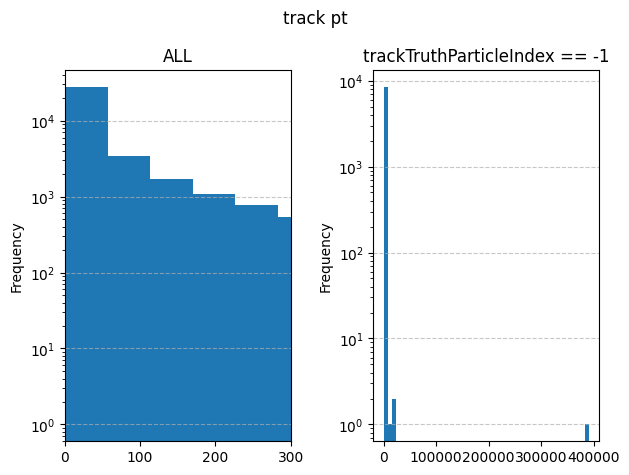

<Figure size 640x480 with 0 Axes>

In [8]:
# Create subplots
fig, axs = plt.subplots(1, 2)
fig.suptitle('track pt')

# Plot for LEFT
axs[0].hist(pt, bins=20000, label="track_pt")
axs[0].set_title(f'ALL')
axs[0].set_xlim(0, 300)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_yscale('log')
#
axs[0].set_ylabel('Frequency')

# Plot for RIGHT
axs[1].hist(pt[mask], bins=50, label="track_pt")
axs[1].set_title(f'trackTruthParticleIndex == -1')
axs[0].set_xlim(0, 300)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_yscale('log')
#
axs[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
plt.clf()

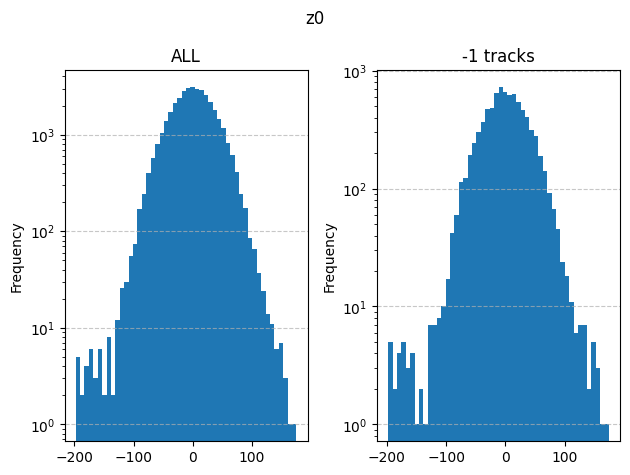

<Figure size 640x480 with 0 Axes>

In [9]:
# Create subplots
fig, axs = plt.subplots(1, 2)
fig.suptitle('z0')

# Plot for LEFT
axs[0].hist(z0, bins=50, label="track_pt")
axs[0].set_title(f'ALL')
#axs[0].set_xlim(0, 300)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_yscale('log')
#
axs[0].set_ylabel('Frequency')

# Plot for RIGHT
axs[1].hist(z0[mask], bins=50, label="track_pt")
axs[1].set_title(f'-1 tracks')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_yscale('log')
#
axs[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
plt.clf()

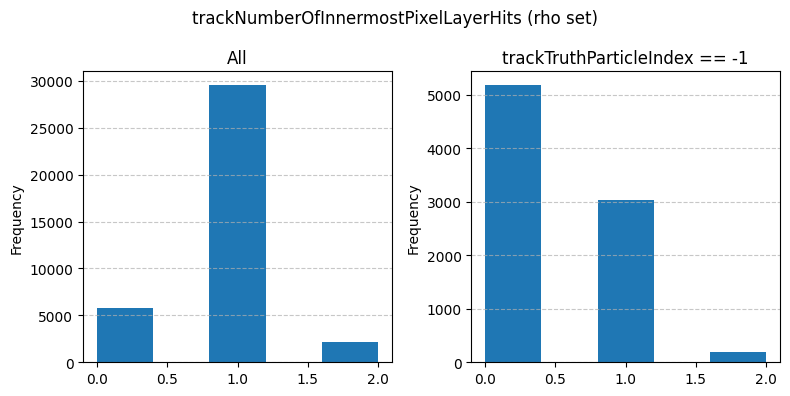

<Figure size 640x480 with 0 Axes>

In [19]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('trackNumberOfInnermostPixelLayerHits (rho set)')

# Plot for LEFT
axs[0].hist(inner_pixel_hits, bins=5, label="track_pt")
axs[0].set_title(f'All')

axs[0].grid(axis='y', linestyle='--', alpha=0.7)
#axs[0].set_yscale('log')
#
axs[0].set_ylabel('Frequency')

# Plot for RIGHT
axs[1].hist(inner_pixel_hits[mask], bins=5, label="track_pt")
axs[1].set_title(f'trackTruthParticleIndex == -1')

axs[1].grid(axis='y', linestyle='--', alpha=0.7)
#axs[1].set_yscale('log')
#
axs[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('inner_hits_rho.png', dpi=400)
plt.show()
plt.clf()

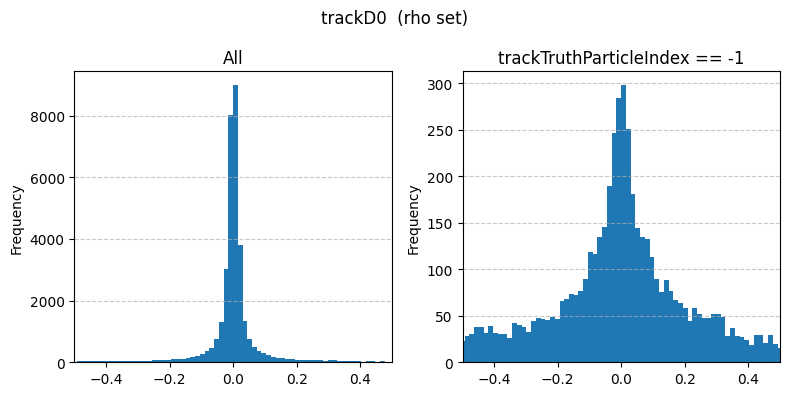

<Figure size 640x480 with 0 Axes>

In [11]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('trackD0  (rho set)')

# Plot for LEFT
axs[0].hist(d0, bins=5000)
axs[0].set_title(f'All')
axs[0].set_xlim(-0.5, 0.5)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
#axs[0].set_yscale('log')
#
axs[0].set_ylabel('Frequency')

# Plot for RIGHT
axs[1].hist(d0[mask], bins=5000)
axs[1].set_title(f'trackTruthParticleIndex == -1')
axs[1].set_xlim(-0.5, 0.5)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
#axs[1].set_yscale('log')
#
axs[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('D0_rho.png', dpi=400)
plt.show()
plt.clf()

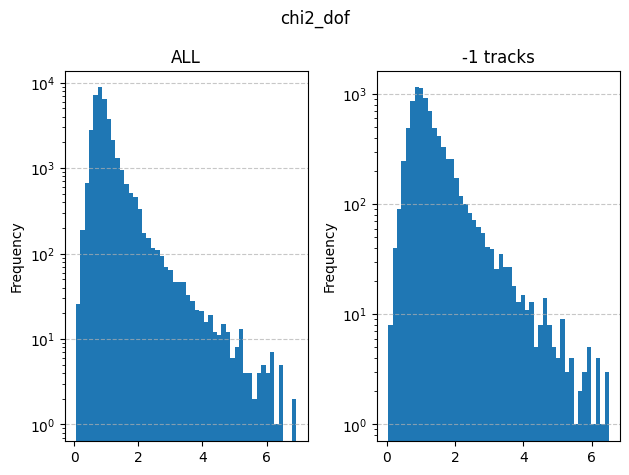

<Figure size 640x480 with 0 Axes>

In [12]:
# Create subplots
fig, axs = plt.subplots(1, 2)
fig.suptitle('chi2_dof')

# Plot for LEFT
axs[0].hist(chi2_dof, bins=50, label="track_pt")
axs[0].set_title(f'ALL')
#axs[0].set_xlim(0, 300)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_yscale('log')
#
axs[0].set_ylabel('Frequency')

# Plot for RIGHT
axs[1].hist(chi2_dof[mask], bins=50, label="track_pt")
axs[1].set_title(f'-1 tracks')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_yscale('log')
#
axs[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
plt.clf()

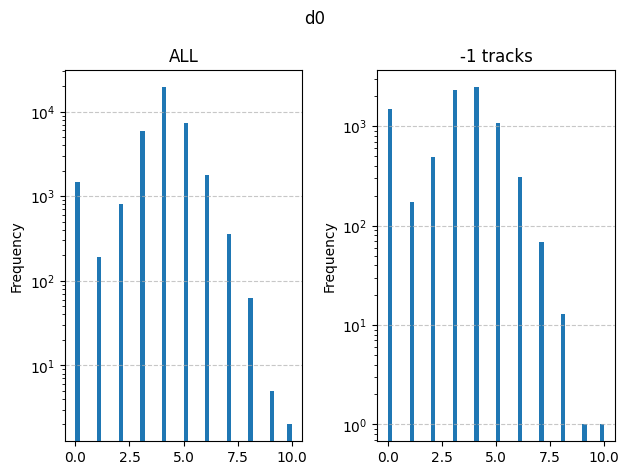

<Figure size 640x480 with 0 Axes>

In [13]:
# Create subplots
fig, axs = plt.subplots(1, 2)
fig.suptitle('d0')

# Plot for LEFT
axs[0].hist(pixel_hits, bins=50, label="track_pt")
axs[0].set_title(f'ALL')
#axs[0].set_xlim(0, 300)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_yscale('log')
#
axs[0].set_ylabel('Frequency')

# Plot for RIGHT
axs[1].hist(pixel_hits[mask], bins=50, label="track_pt")
axs[1].set_title(f'-1 tracks')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_yscale('log')
#
axs[1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
plt.clf()

In [14]:
root_file = "/fast_scratch_1/atlas/pflow/20240626/user.mswiatlo.mc21_13p6TeV.900148.singlerho.recon.ESD.e8537_e8455_s3986_s3874_r14060_2024.06.26.v1_mltree.root/user.mswiatlo.40097513._000001.mltree.root"
#root_file="/fast_scratch_1/atlas/pflow/20240614/user.mswiatlo.801169.Py8EG_A14NNPDF23LO_jj_JZ4.recon.ESD.e8514_e8528_s4185_s4114_r14977_2024.06.14.1_mltree.root/user.mswiatlo.39955735._000003.mltree.root"


root_file = uproot.open(root_file)

hits_arr = root_file["EventTree;1"]['cluster_cell_hitsTruthE'].array()
index_arr = root_file["EventTree;1"]['cluster_cell_ID'].array(library="ak")

def dife(event):
    try:
        result = len(ak.flatten(index_arr[event])) - len(set(ak.flatten(index_arr[event])))
        if result!= 0:
            print(event, result)
    except:
        result = -50
    return result
        

dif = [dife(event) for event in range(1000)]

6 19
13 9
17 2
18 2
19 4
23 10
27 6
28 23
31 8
32 1
35 13
37 5
41 2
44 27
45 17
48 32
49 51
50 2
51 4
52 4
54 3
57 2
59 4
60 9
61 52
65 34
67 1
68 2
71 3
72 1
73 6
77 7
79 11
81 14
84 8
90 19
92 7
94 9
95 1
96 2
100 11
101 3
110 32
111 10
116 6
117 9
124 1
125 12
126 11
127 4
131 4
133 19
134 6
135 15
136 120
137 47
138 16
142 20
143 7
148 3
149 14
152 9
154 22
157 1
158 11
159 35
161 4
164 11
165 10
170 17
171 11
172 24
175 6
178 13
179 7
180 5
182 2
185 7
187 10
188 1
193 19
196 3
197 1
198 3
199 5
200 1
205 4
209 21
210 60
214 23
215 1
218 5
222 2
224 4
225 20
233 2
234 62
236 4
238 20
239 7
240 8
243 3
245 4
247 14
248 4
250 23
252 9
258 8
260 10
261 7
263 3
265 7
270 4
272 23
273 7
275 9
277 2
278 2
288 7
290 11
293 4
295 12
296 5
297 1
303 10
304 19
306 19
309 17
311 4
312 13
315 1
321 16
326 1
328 16
329 17
333 6
337 2
346 2
347 4
349 40
352 5
355 18
360 7
363 2
365 12
366 1
371 2
373 22
375 1
376 2
378 11
379 1
380 3
381 7
382 16
383 31
388 9
389 6
390 4
392 2
393 32
394 21
397

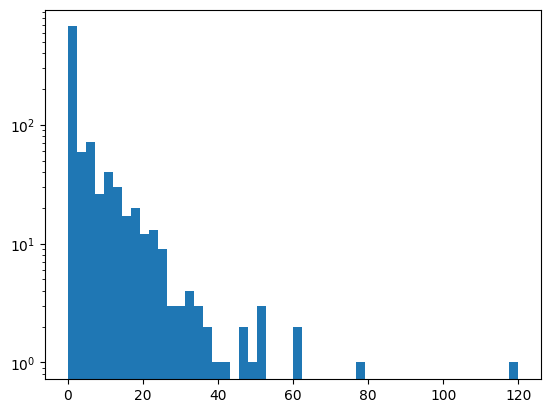

In [15]:
plt.hist(dif, bins=50)
plt.yscale('log')

In [16]:
hits_arr = root_file["EventTree;1"]['cluster_cell_hitsTruthE'].array()
index_arr = root_file["EventTree;1"]['cluster_cell_hitsTruthIndex'].array()

for event in range(len(hits_arr)):
    for cluster in range(len(hits_arr[event])):
        for cell in range(len(hits_arr[event][cluster])):
            if len(hits_arr[event][cluster][cell]) != len(index_arr[event][cluster][cell]):
                print(event, cluster, cell)

KeyboardInterrupt: 

EVENT: 1
Track 0
ERROR ERROR NO CELL ID
cannot slice NumpyArray (of length 0) with 0: index 0 is out of bounds for axis 0 with size 0

This error occurred while attempting to slice

    <Array [] type='0 * int32'>

with

    0
749221464
ERROR ERROR NO CELL ID
cannot slice NumpyArray (of length 0) with 0: index 0 is out of bounds for axis 0 with size 0

This error occurred while attempting to slice

    <Array [] type='0 * int32'>

with

    0
749221976
ERROR ERROR NO CELL ID
cannot slice NumpyArray (of length 0) with 0: index 0 is out of bounds for axis 0 with size 0

This error occurred while attempting to slice

    <Array [] type='0 * int32'>

with

    0
749220440
Cluster 0
Cluster 1
dict_values([[-1.5995706, -1.5995524, -1.5744963, -1.6246243, -1.5893825, -1.592516, -1.5956494, -1.5987828, -1.6019162, -1.6050495, -1.6081828, -1.6113161, -1.5988196, -1.5987631, -1.5894189, -1.5831156, -1.5862491, -1.5862854, -1.6082201, -1.5744779, -1.5831517], [-1.5745134], [-1.8360559, -1.8360181

/tmp/ipykernel_3515505/2467668591.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20, 12))


Track 0
Cluster 0
Cluster 1
Cluster 2
dict_values([[1.798516, 1.7734959, 1.7976294, 1.8007568, 1.7851744, 1.7851624, 1.835189, 1.7350692, 1.7593501, 1.7484586, 1.7351027, 1.7985423, 1.6850059, 1.7601514, 1.7351142, 1.8352275, 1.8852614, 1.8852756, 1.7851996, 1.6591555, 1.6591555, 1.8595104, 1.8554263, 1.8735126, 1.7350584, 1.8595104, 1.7984555, 1.7984333, 1.8234605, 1.773437, 1.823472, 1.7734154, 1.8234493, 1.7850953, 1.7990842, 1.7851058, 1.7483788, 1.8351415, 1.7631327, 1.7787695, 1.6591555, 1.735048, 1.7600054, 1.8851585, 1.6849866, 1.6849961, 1.6591555, 1.6591555, 1.7350584], [1.7734835, 1.8235213, 1.8235344, 1.7734715, 1.8235085, 1.7851506, 1.823496, 1.785139, 1.7883021, 1.798529, 1.7484227, 1.7484344, 1.7484113, 1.7350801, 1.7350912, 1.8352015, 1.8351766, 1.7484463, 1.8485374, 1.8485509, 1.8485243, 1.8485115, 1.7735084, 1.8235477, 1.8485647, 1.8070679, 1.7851746, 1.8351647, 1.7233994, 1.7234107, 1.7413305, 1.7444586, 1.7234223, 1.8735387, 1.8735523, 1.7735213, 1.8235614, 1.885207

KeyboardInterrupt: 

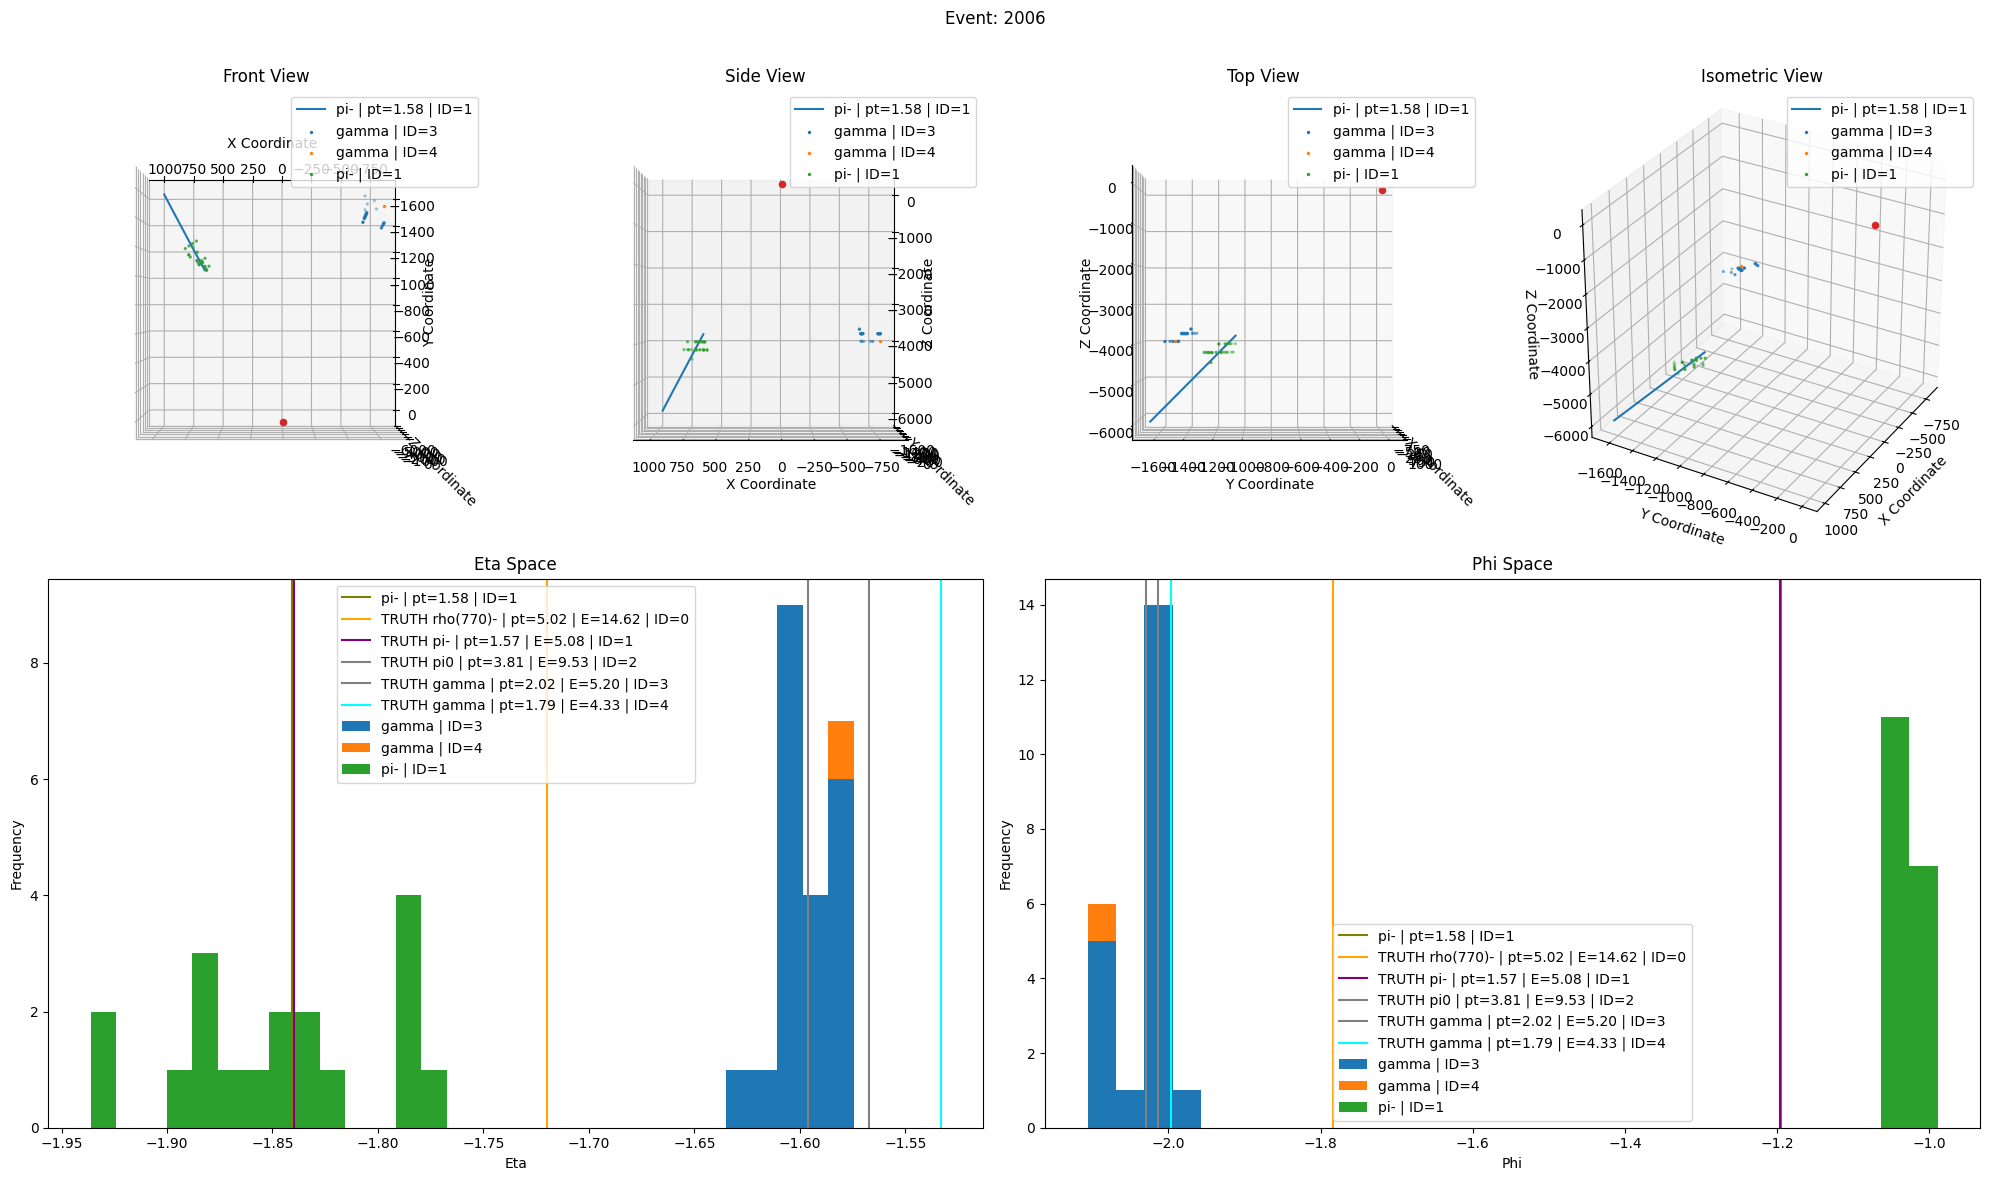

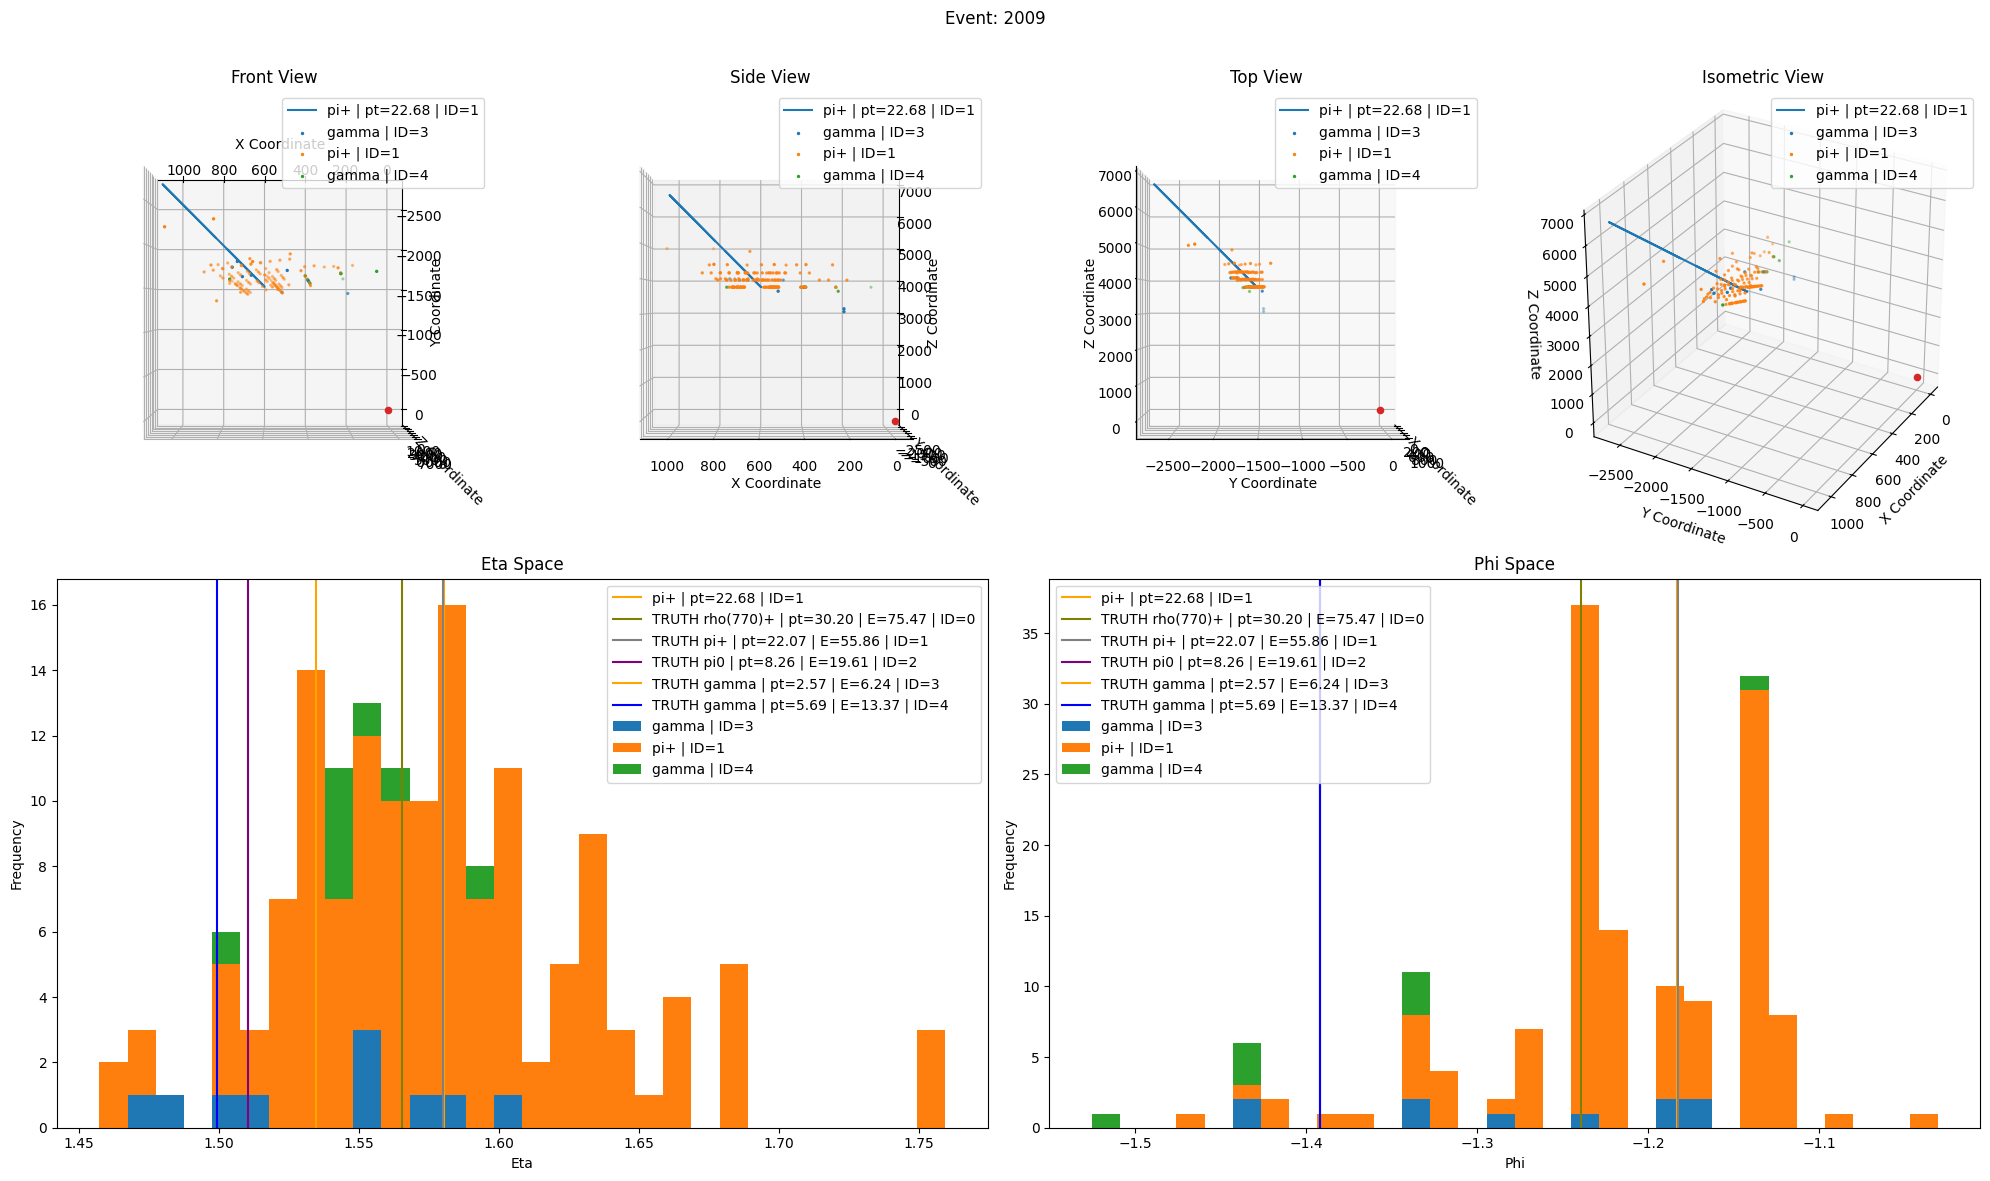

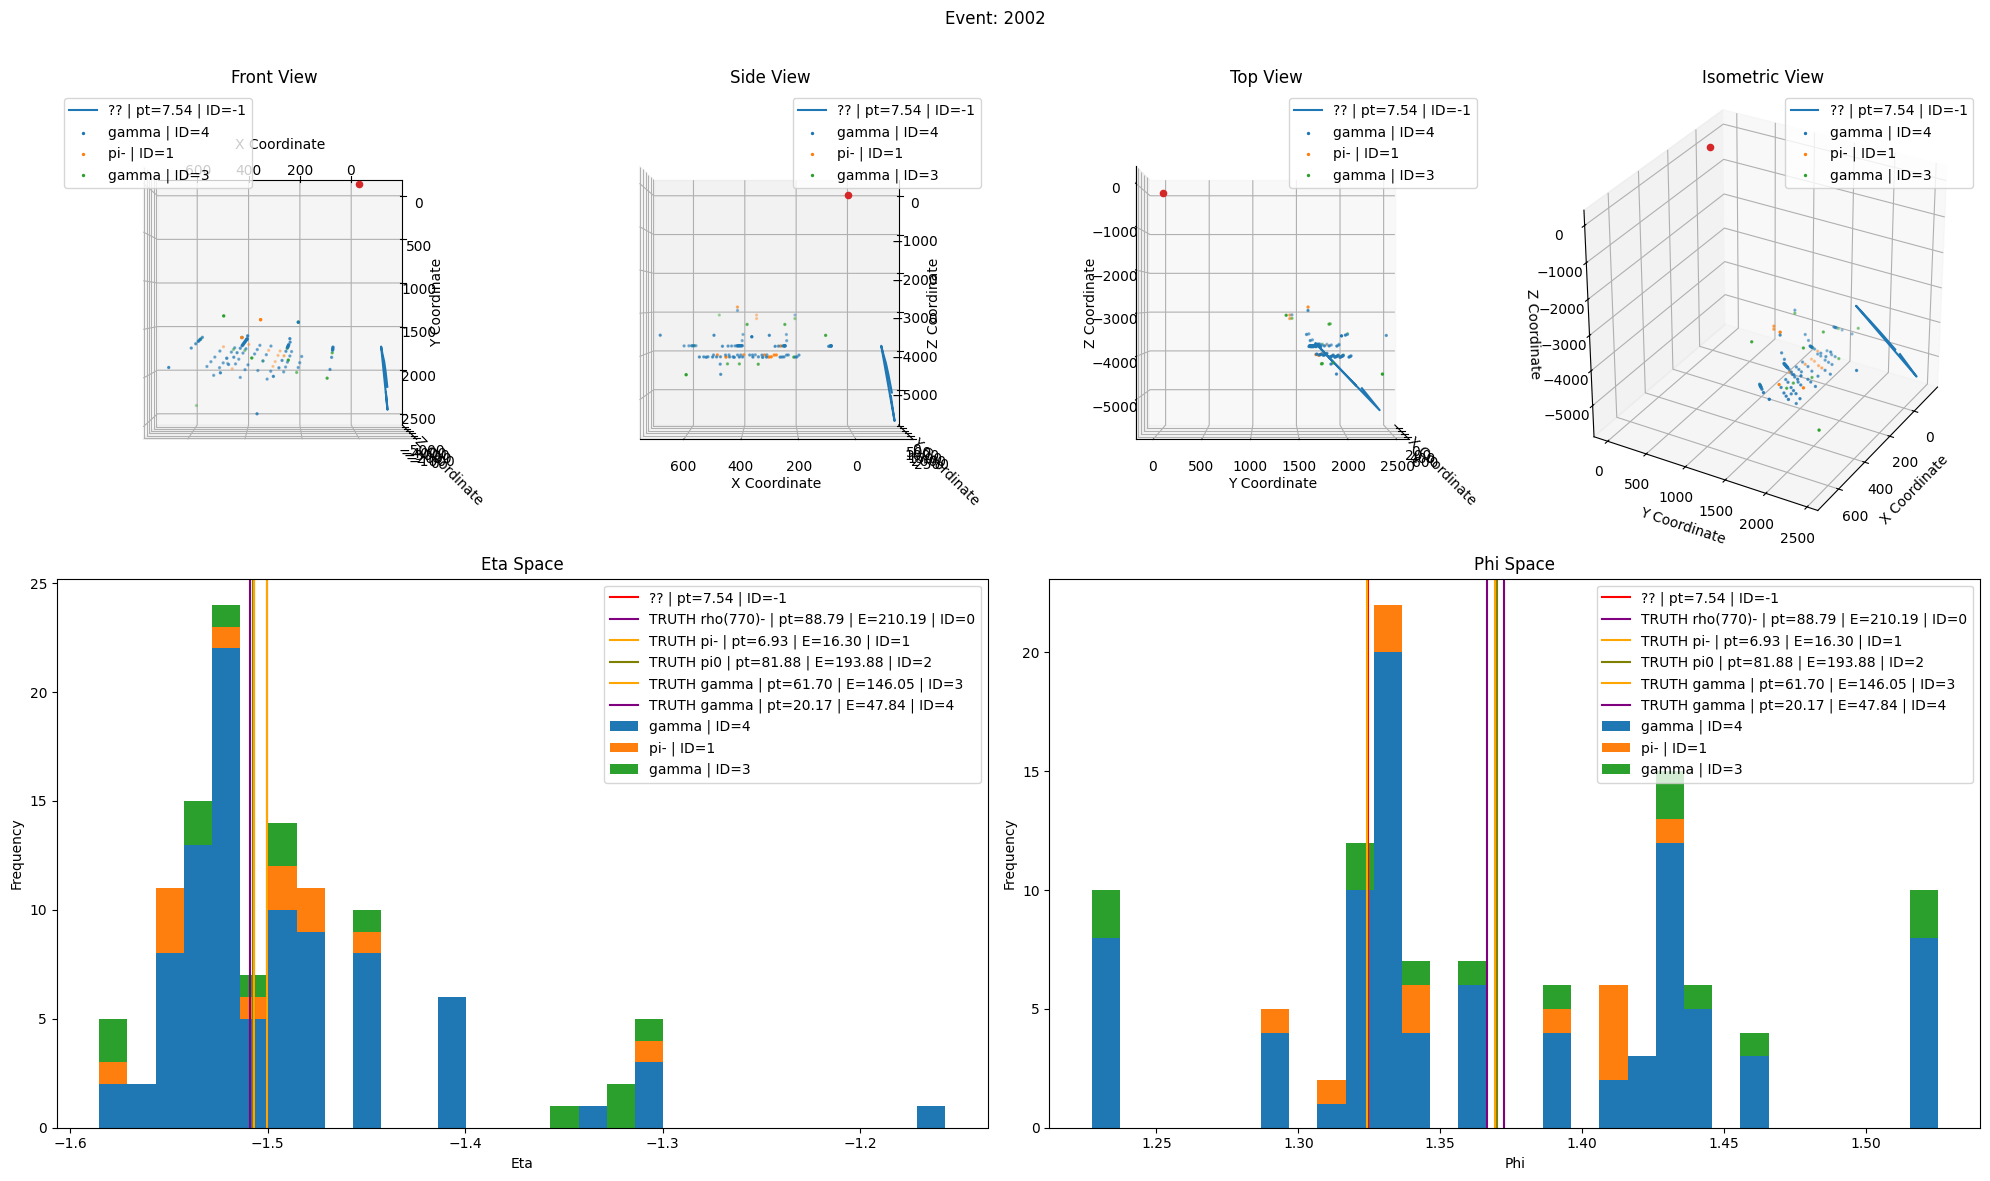

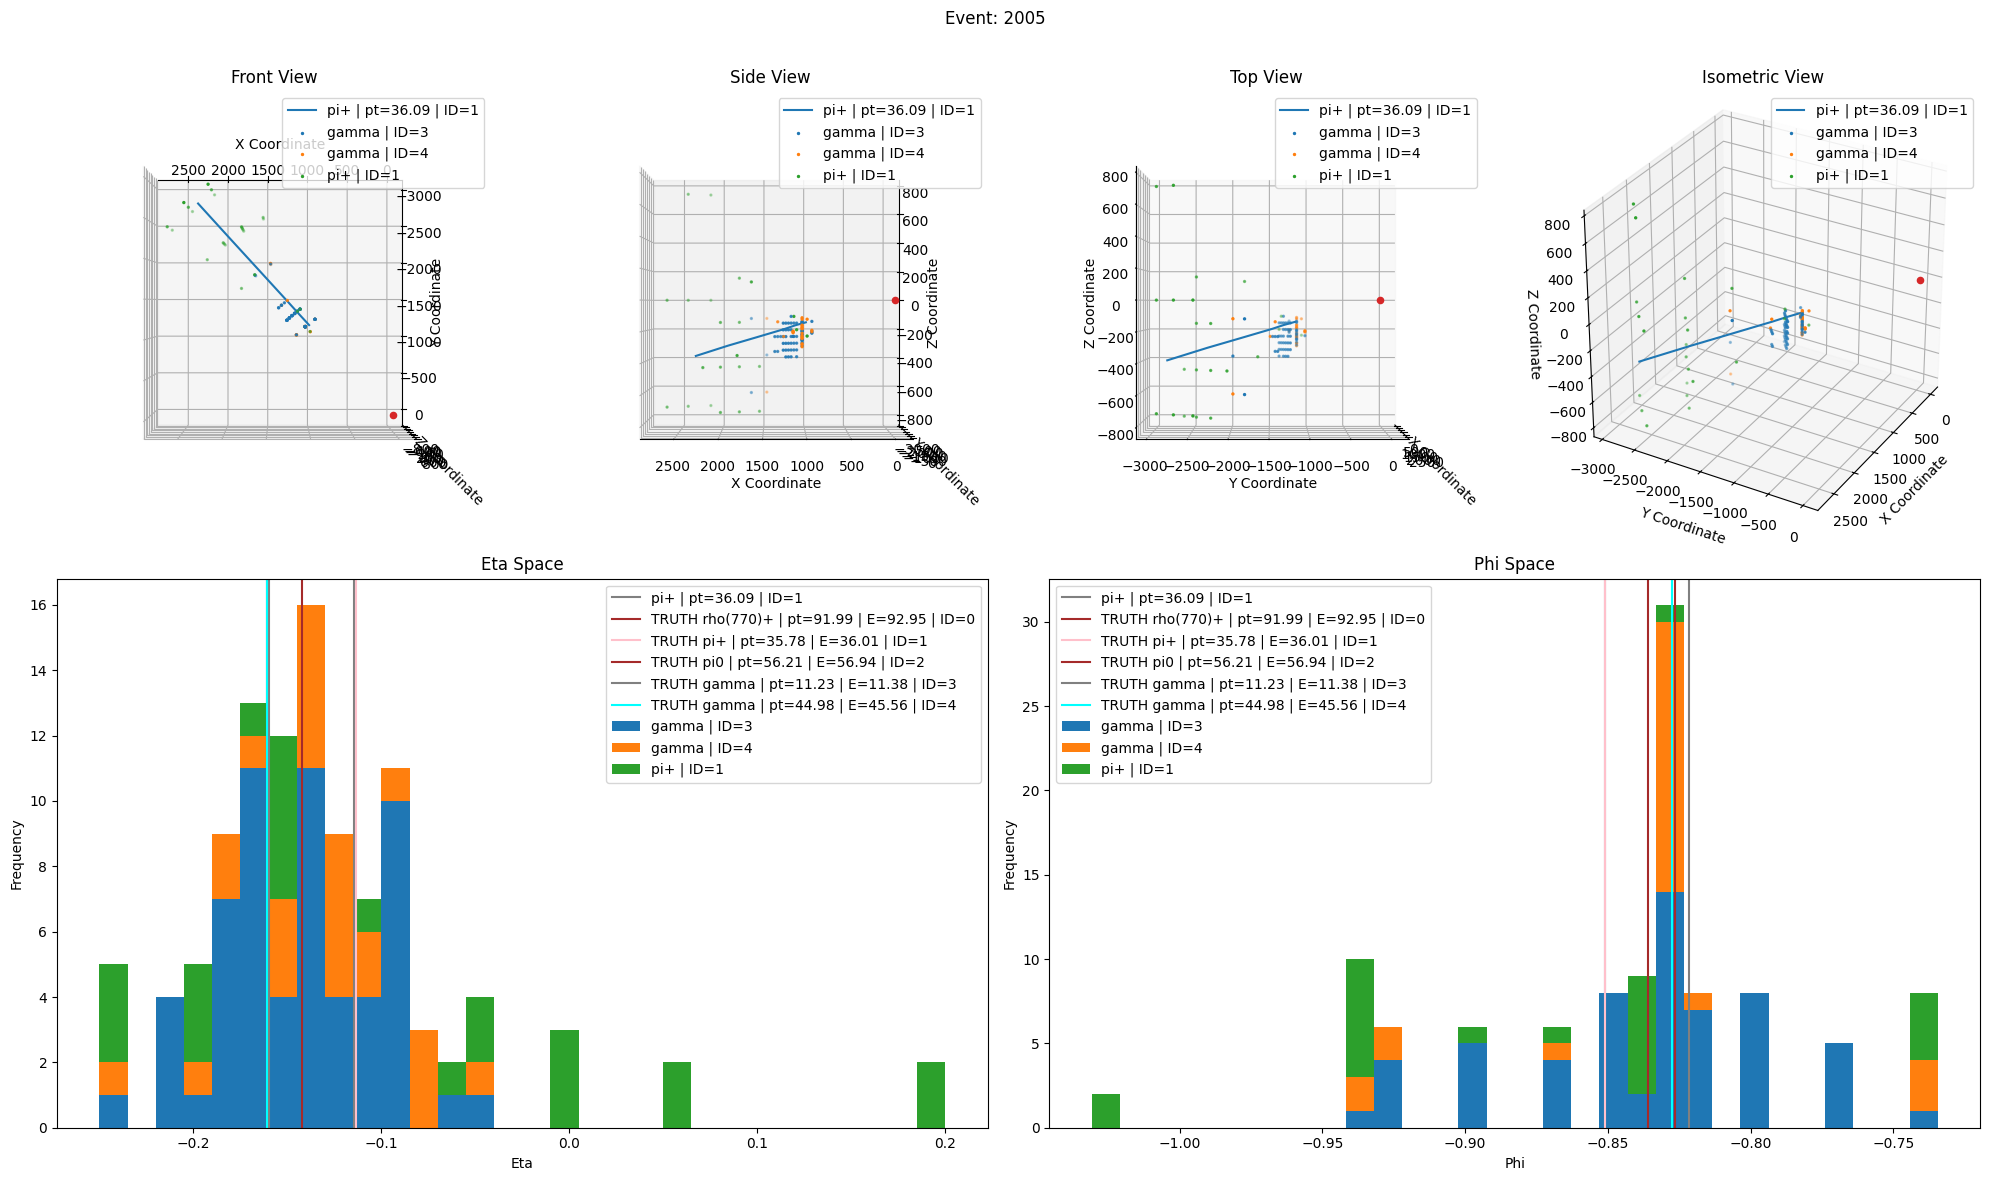

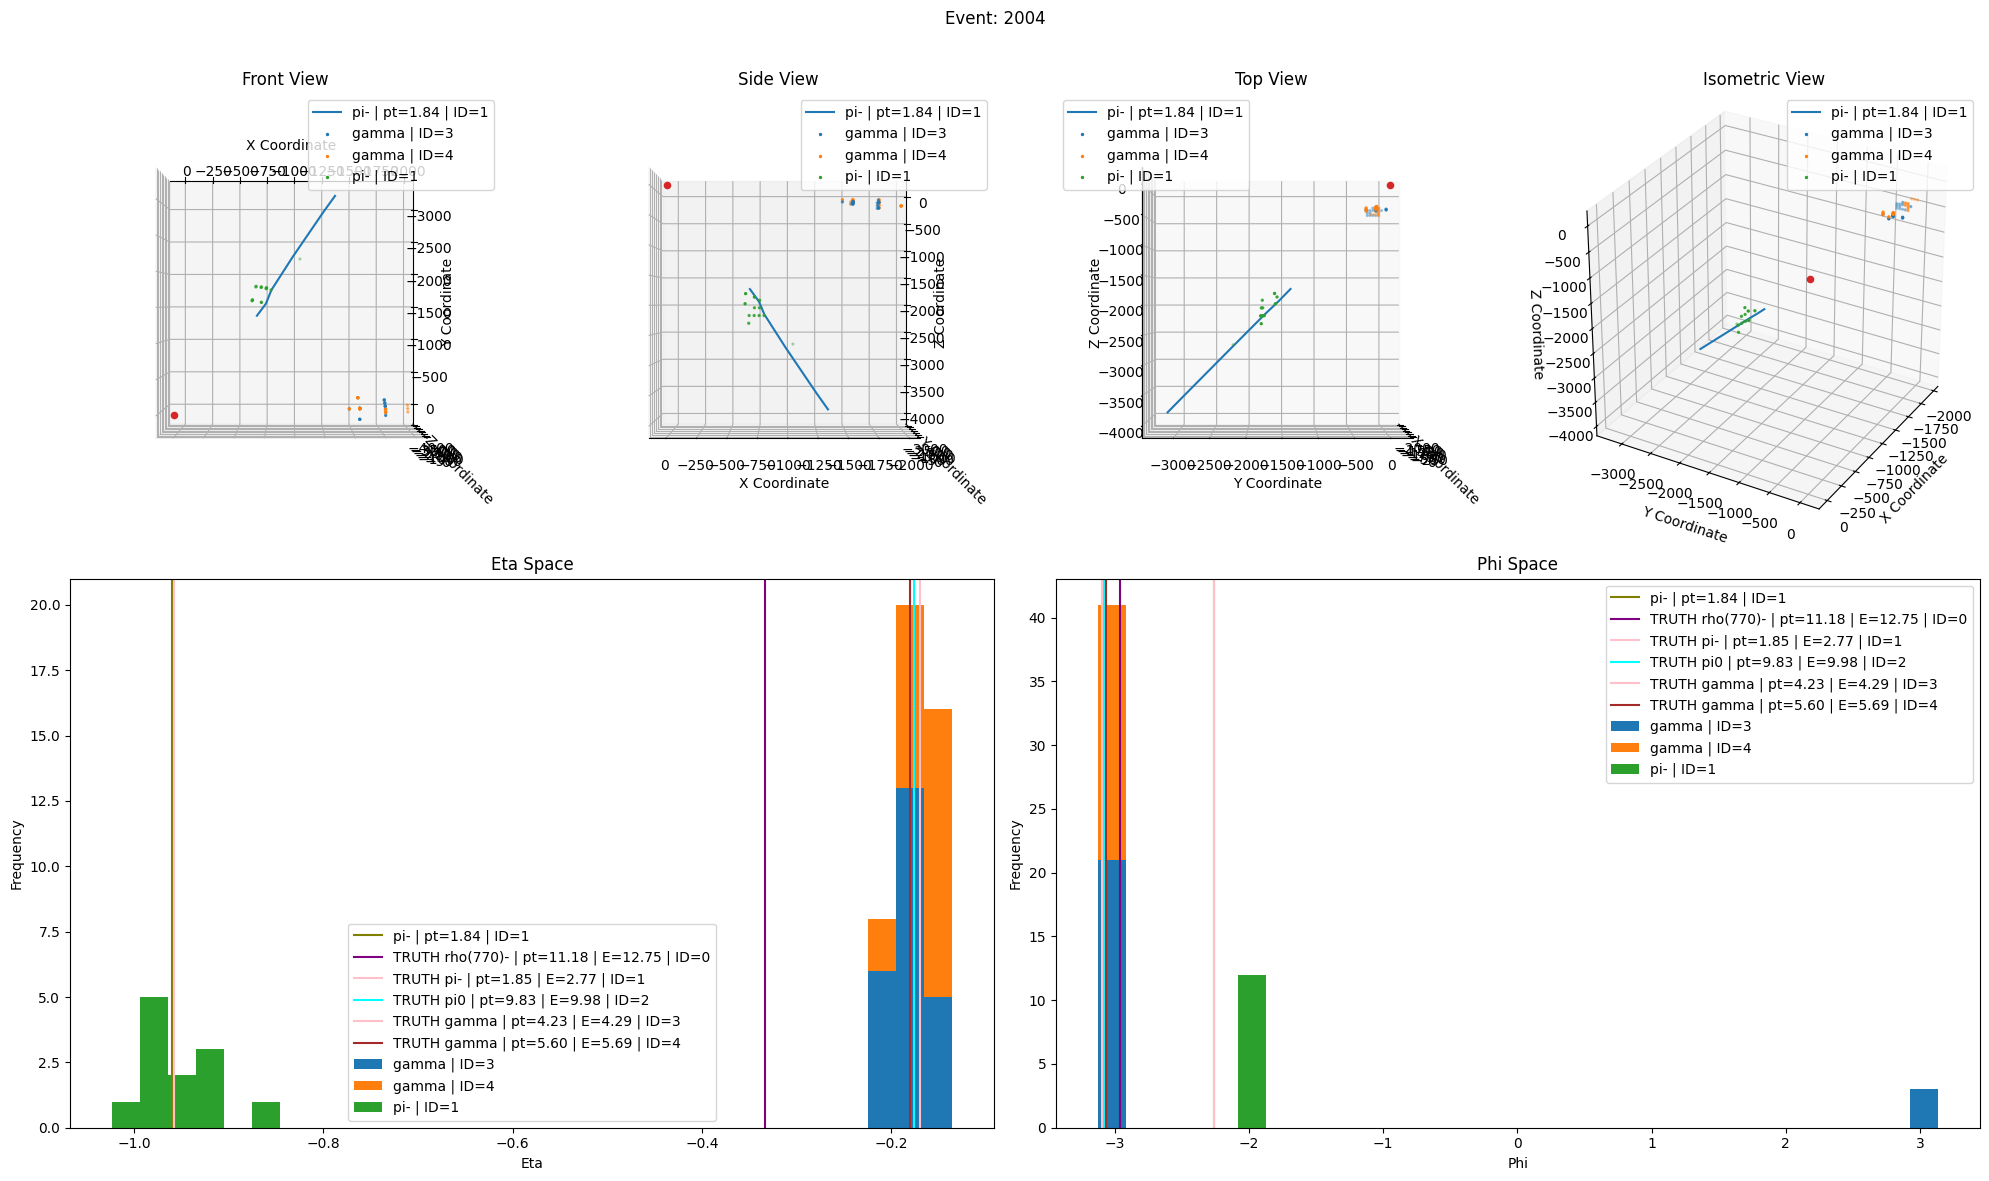

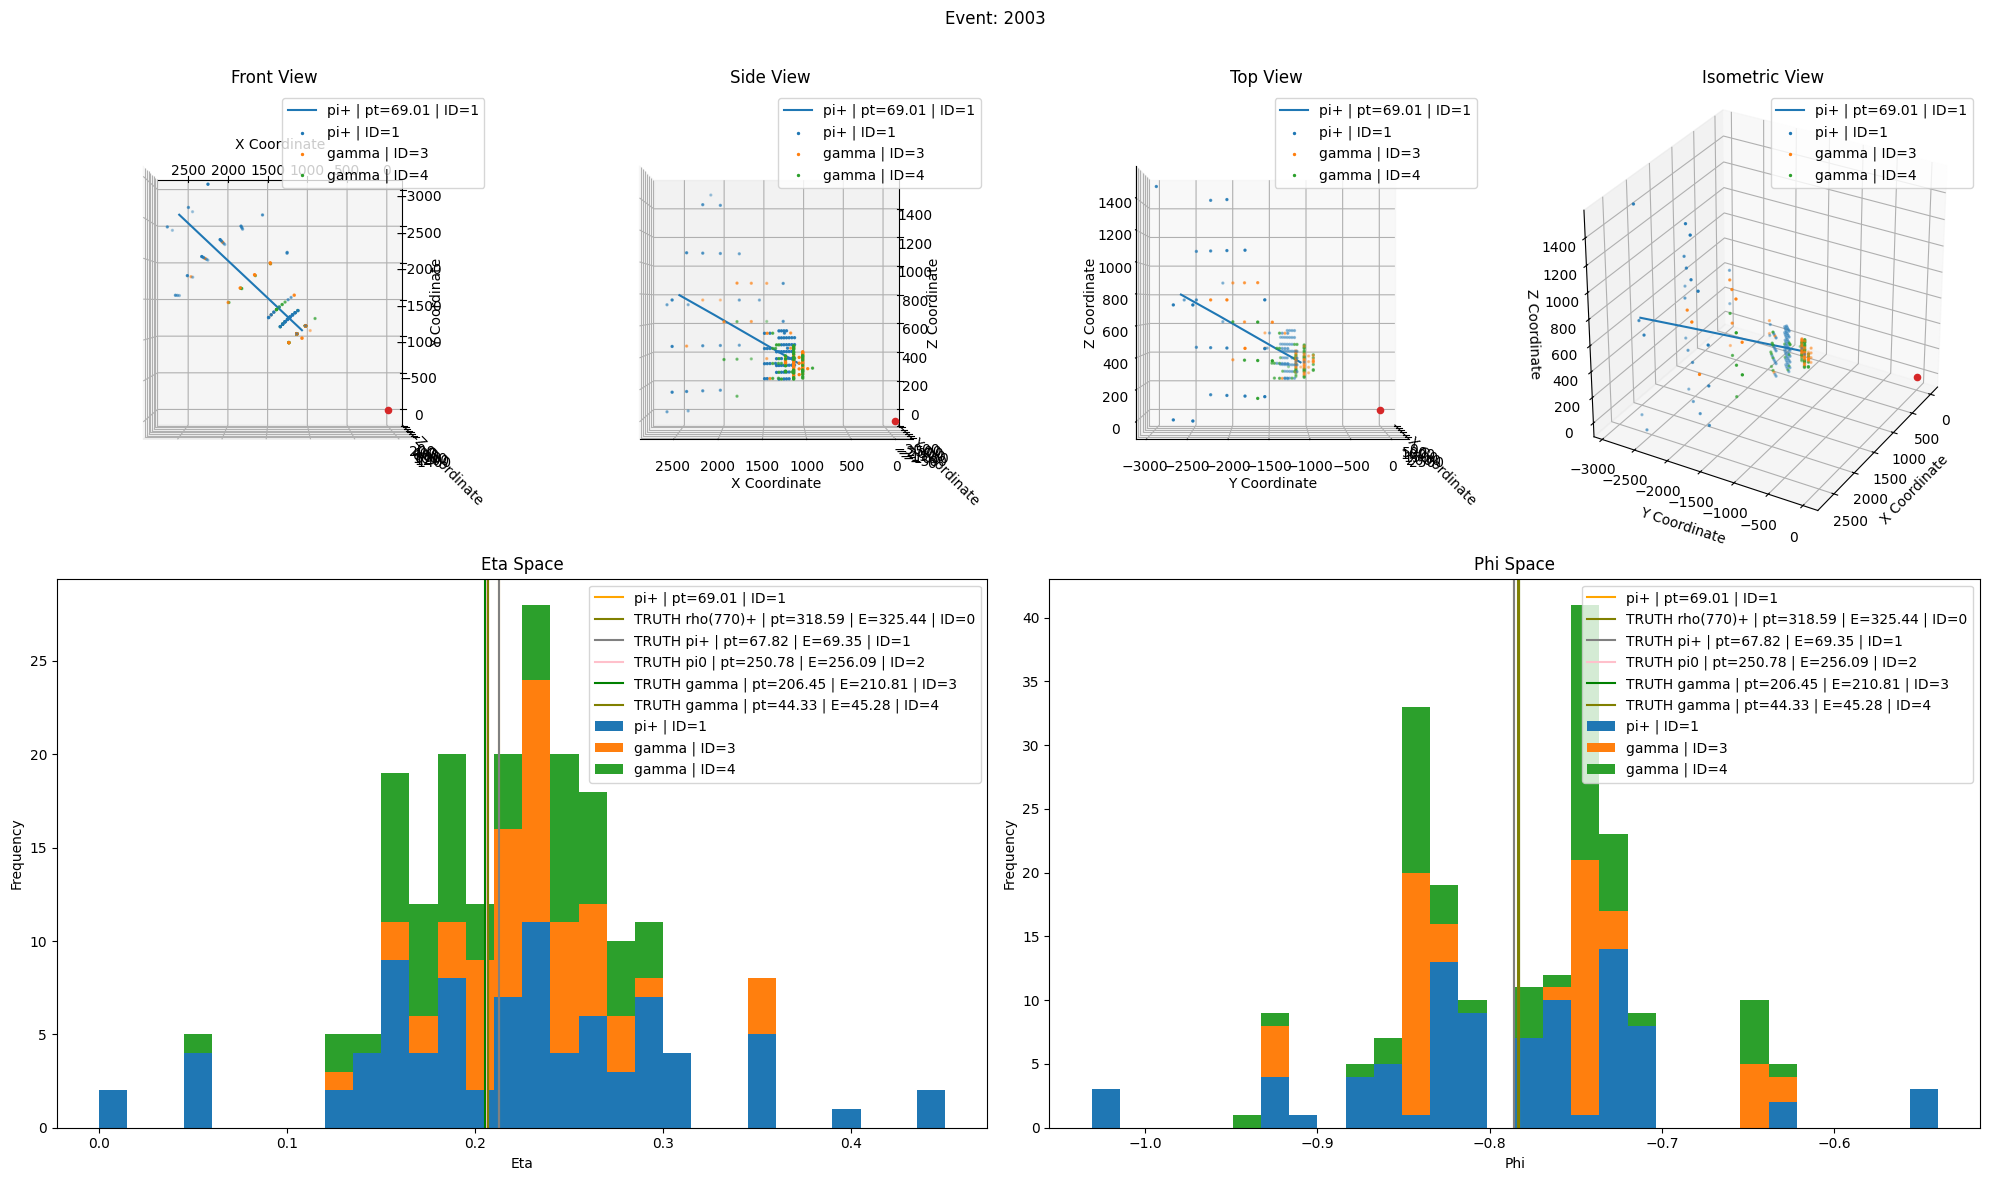

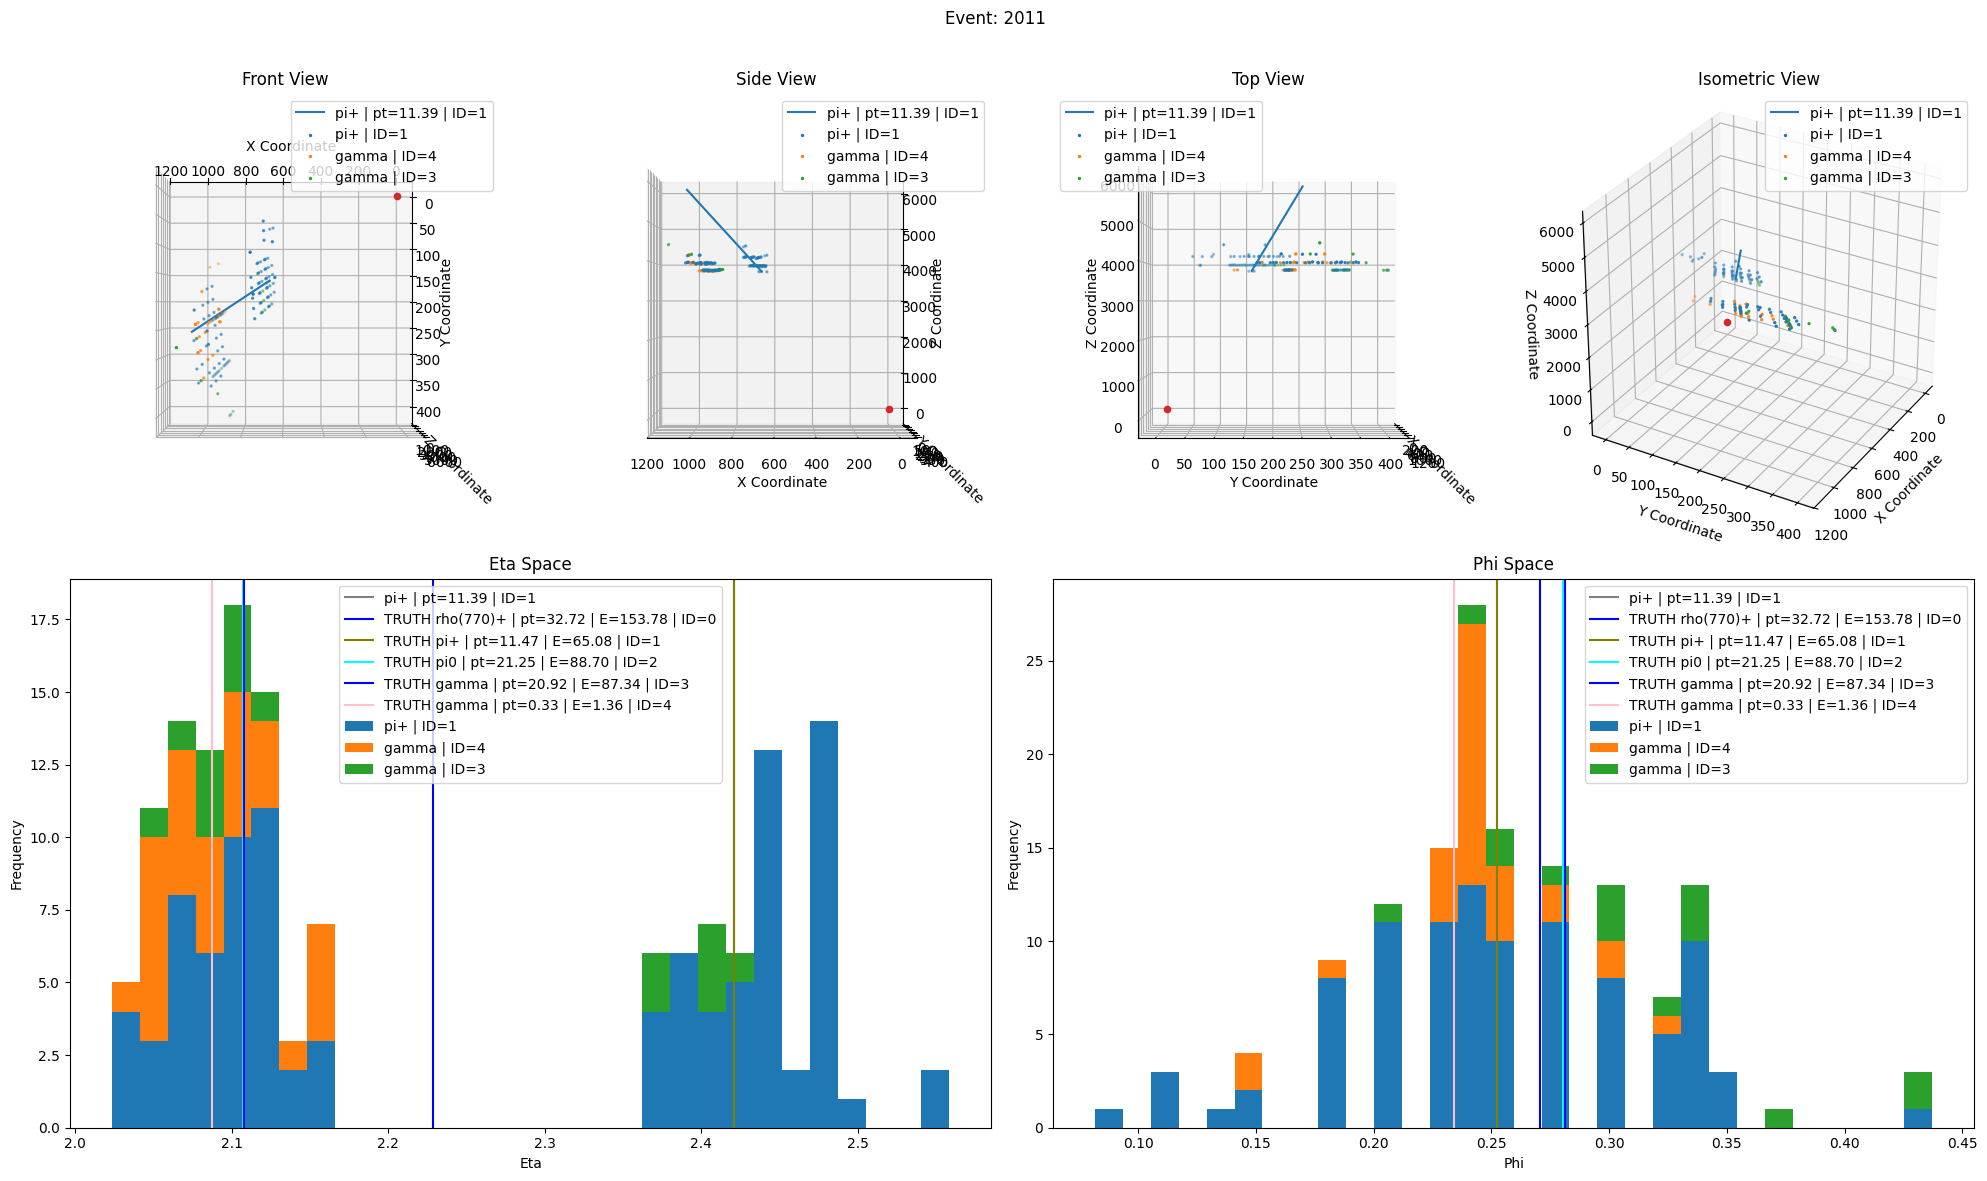

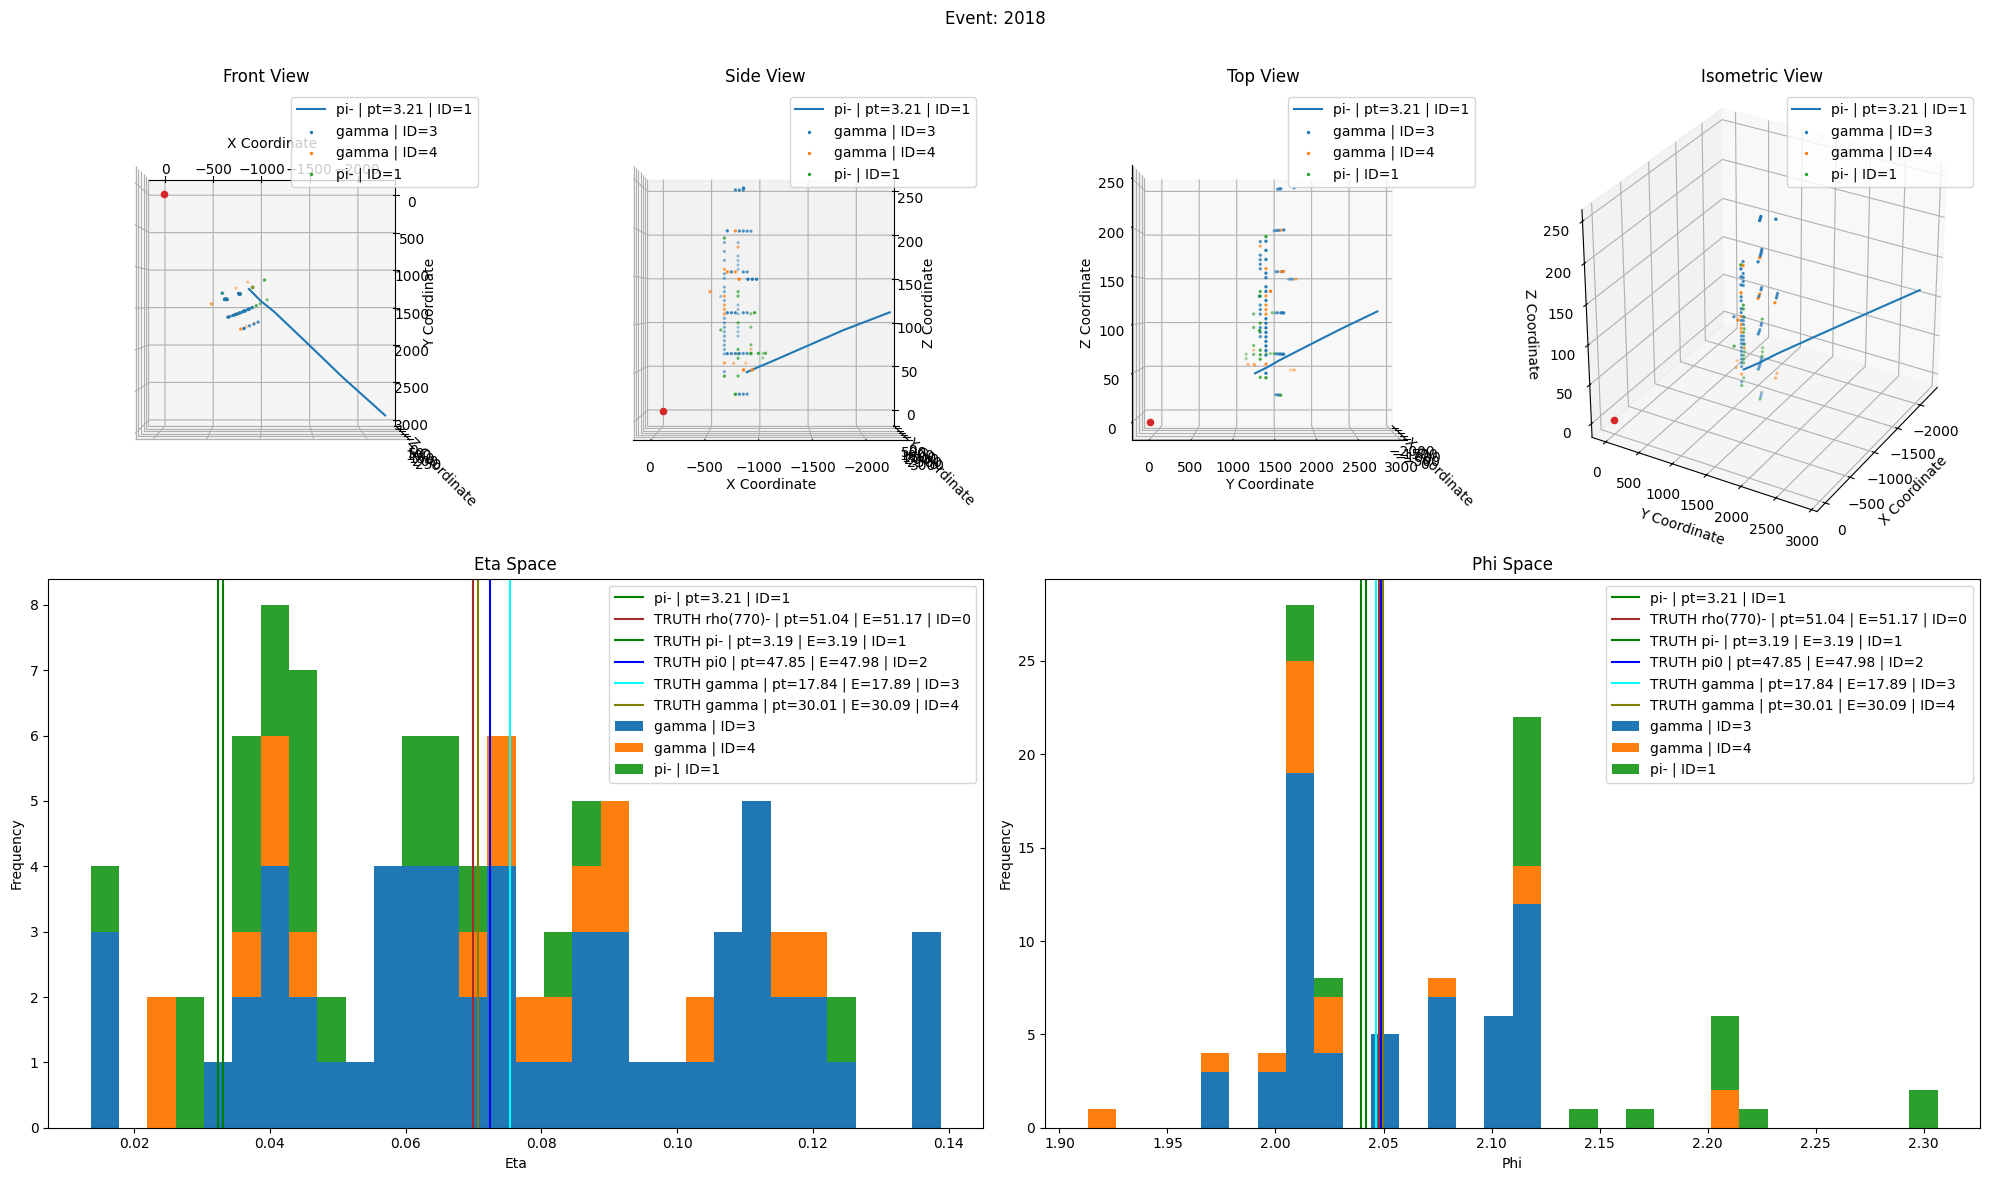

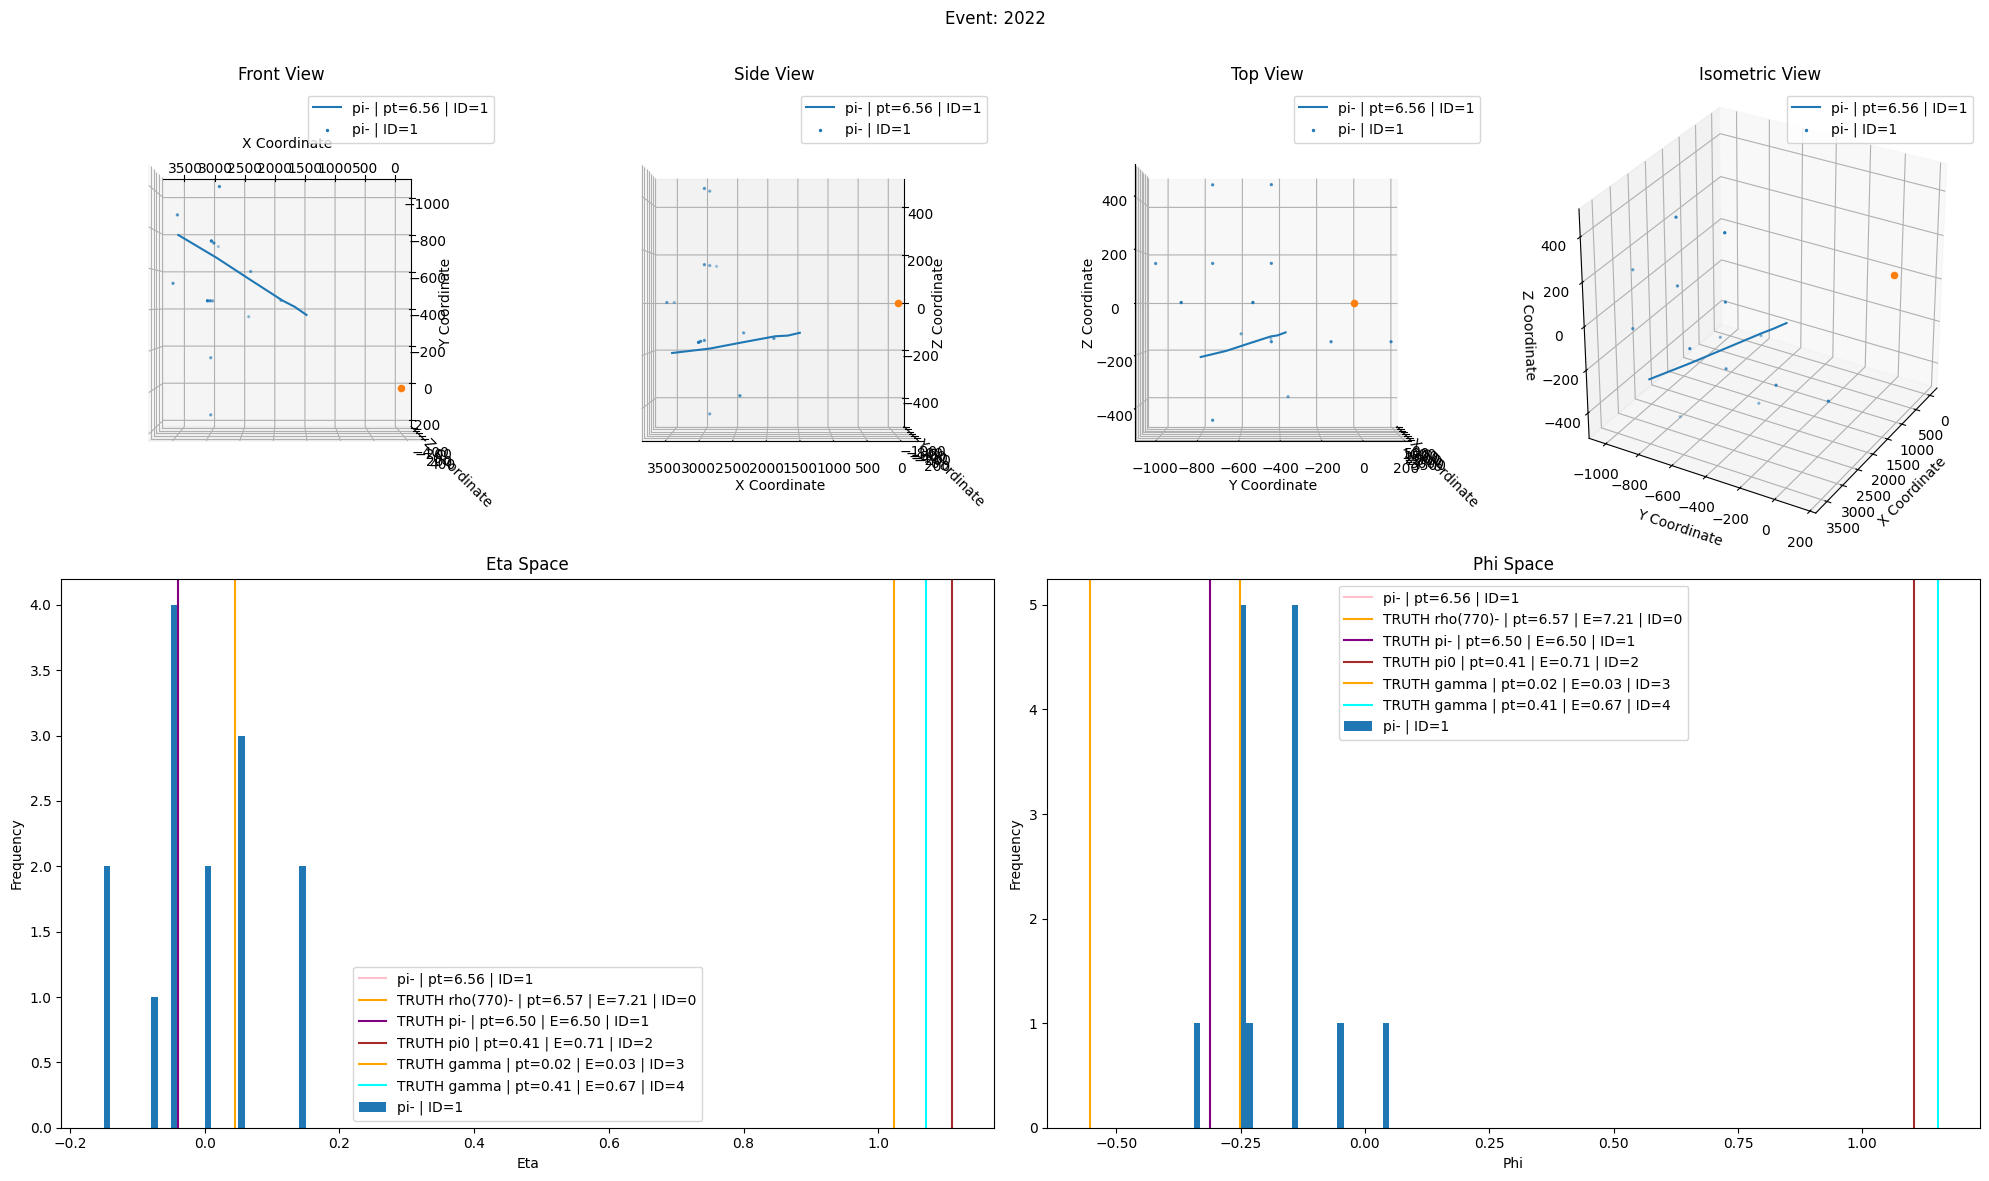

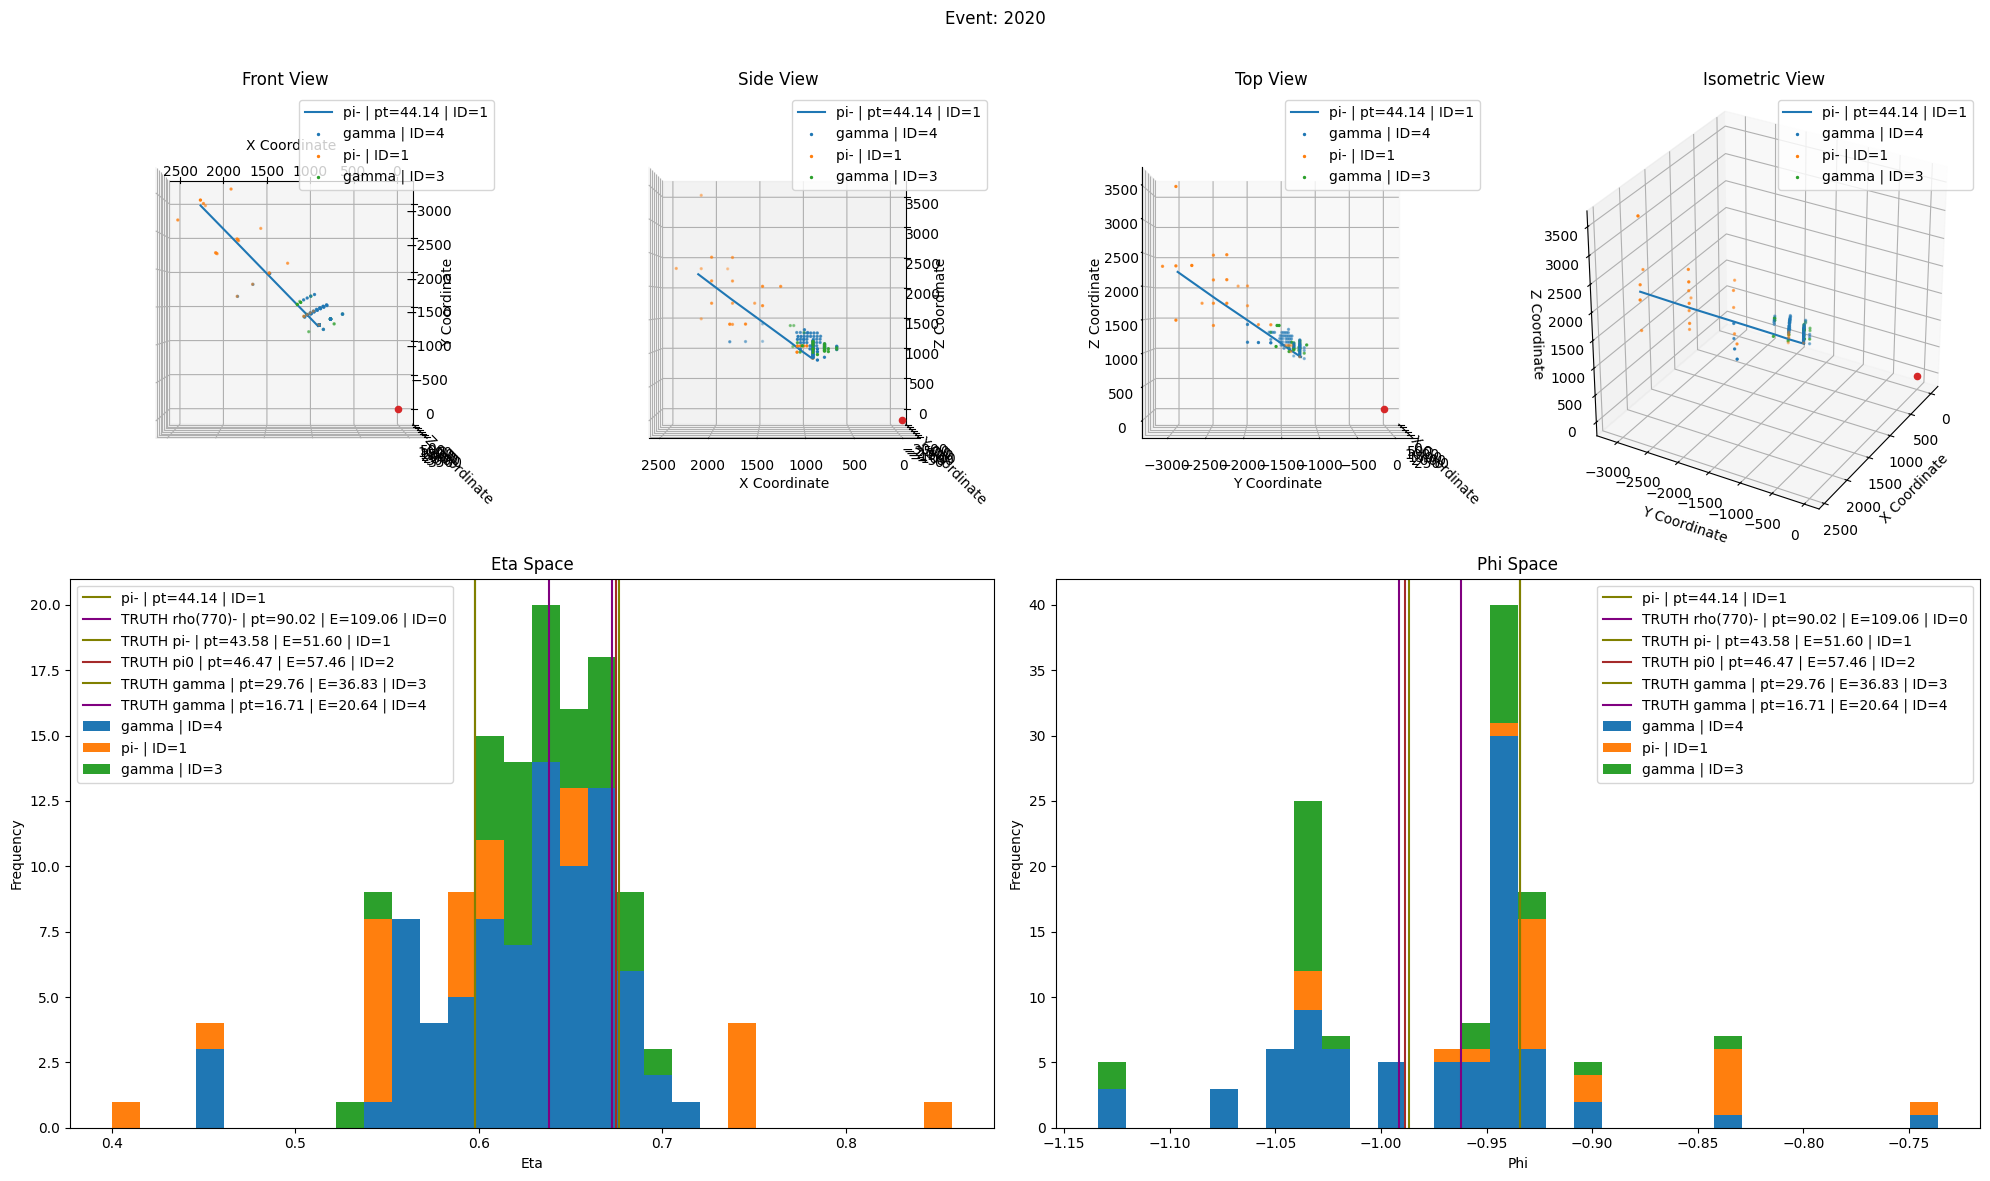

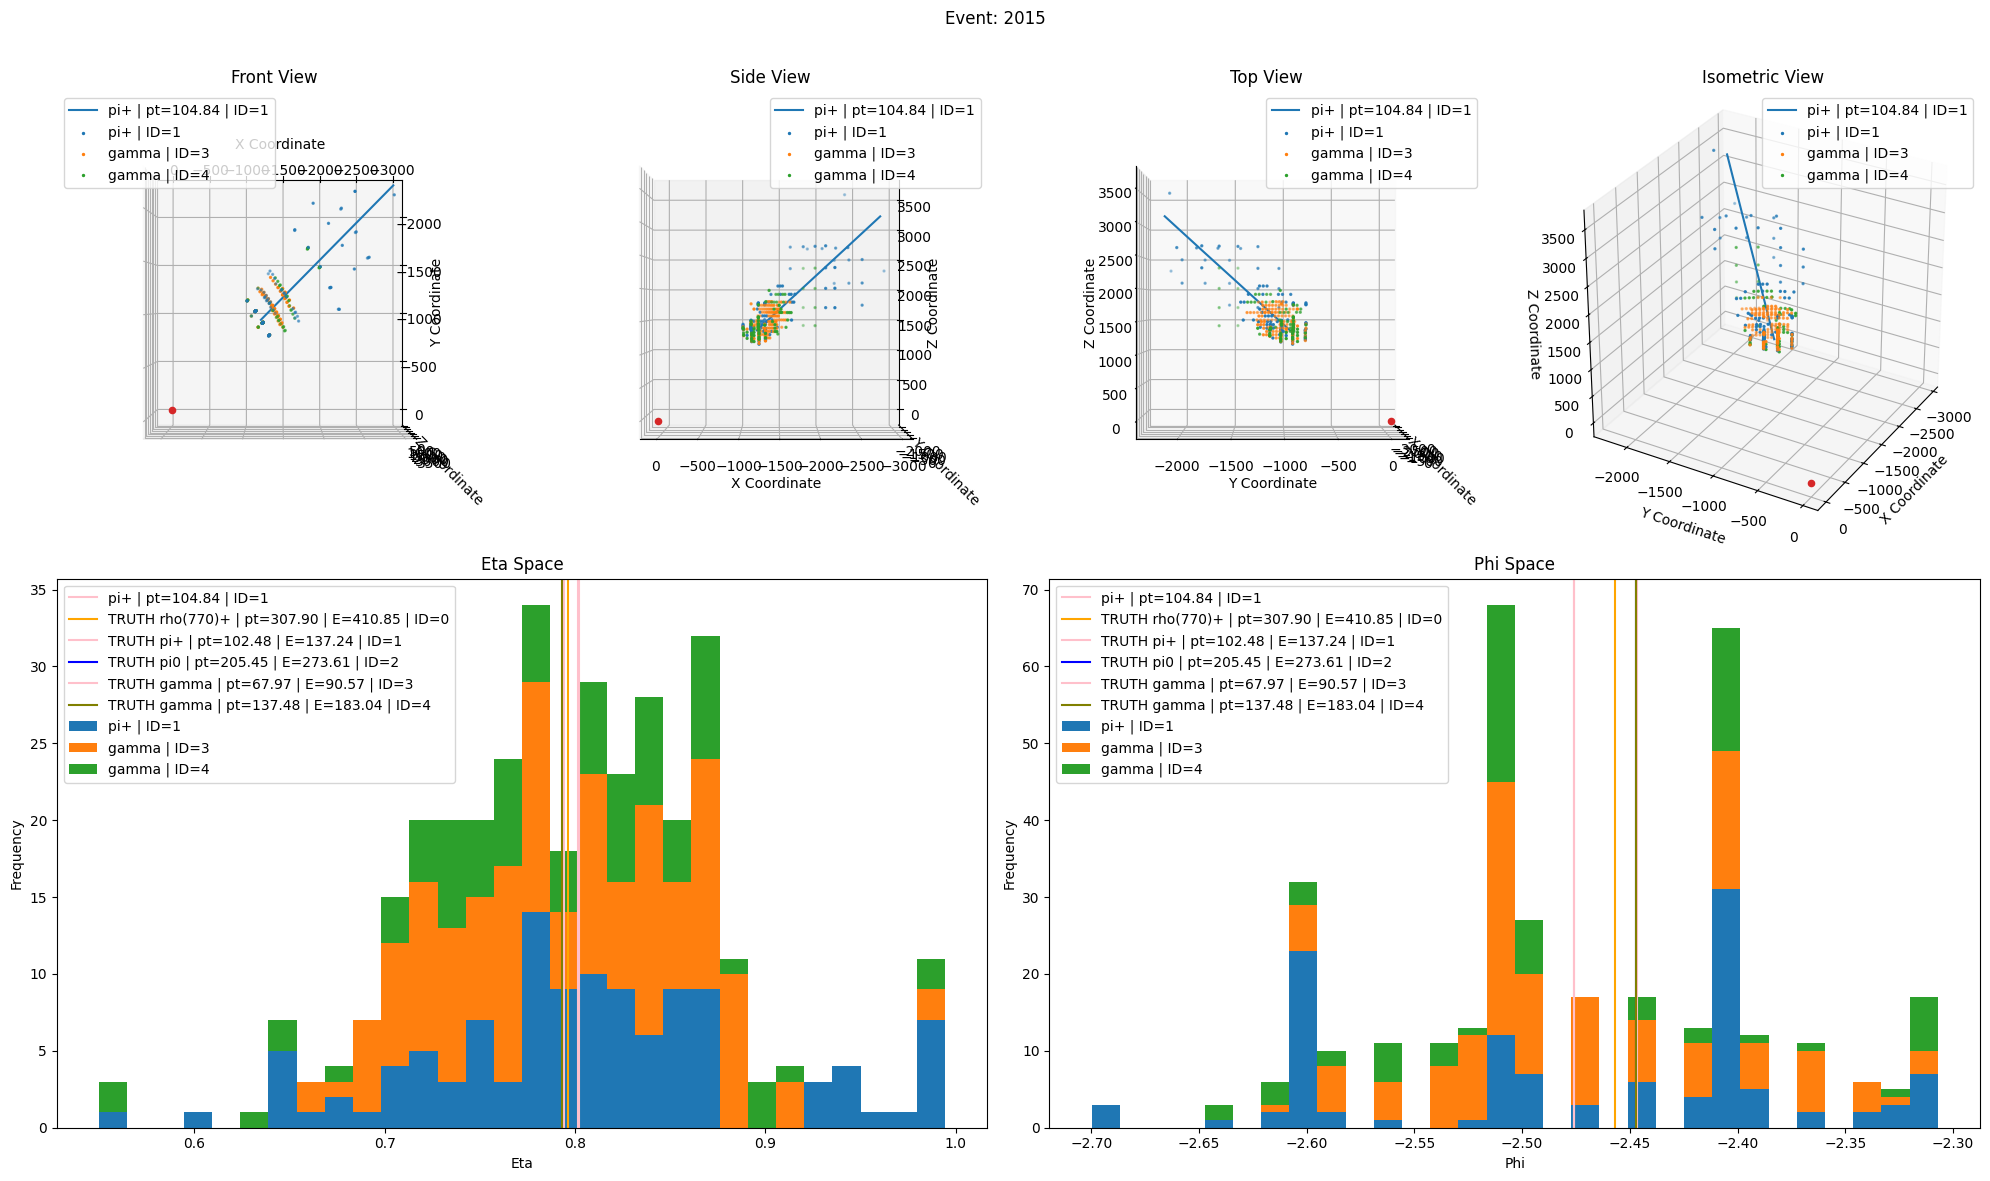

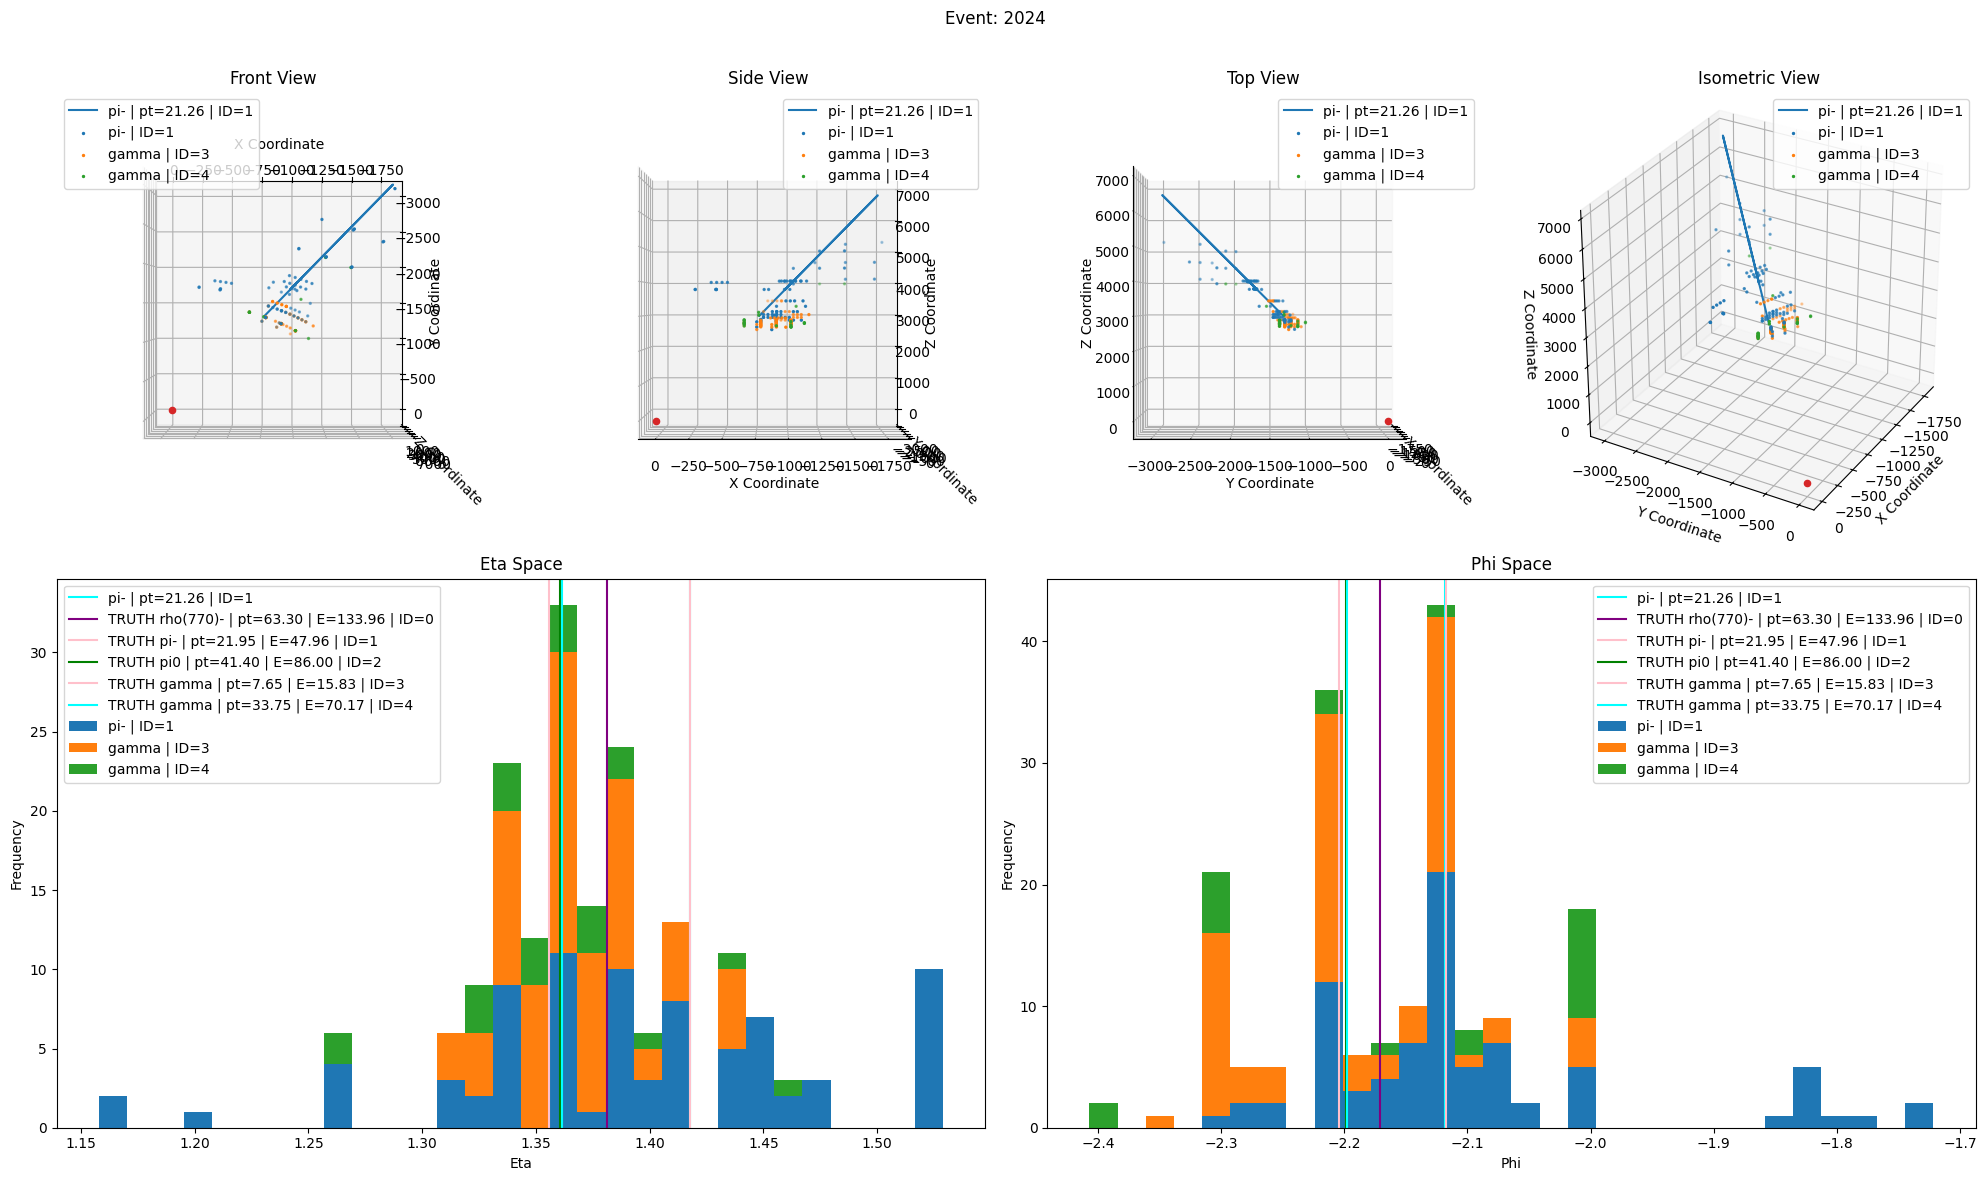

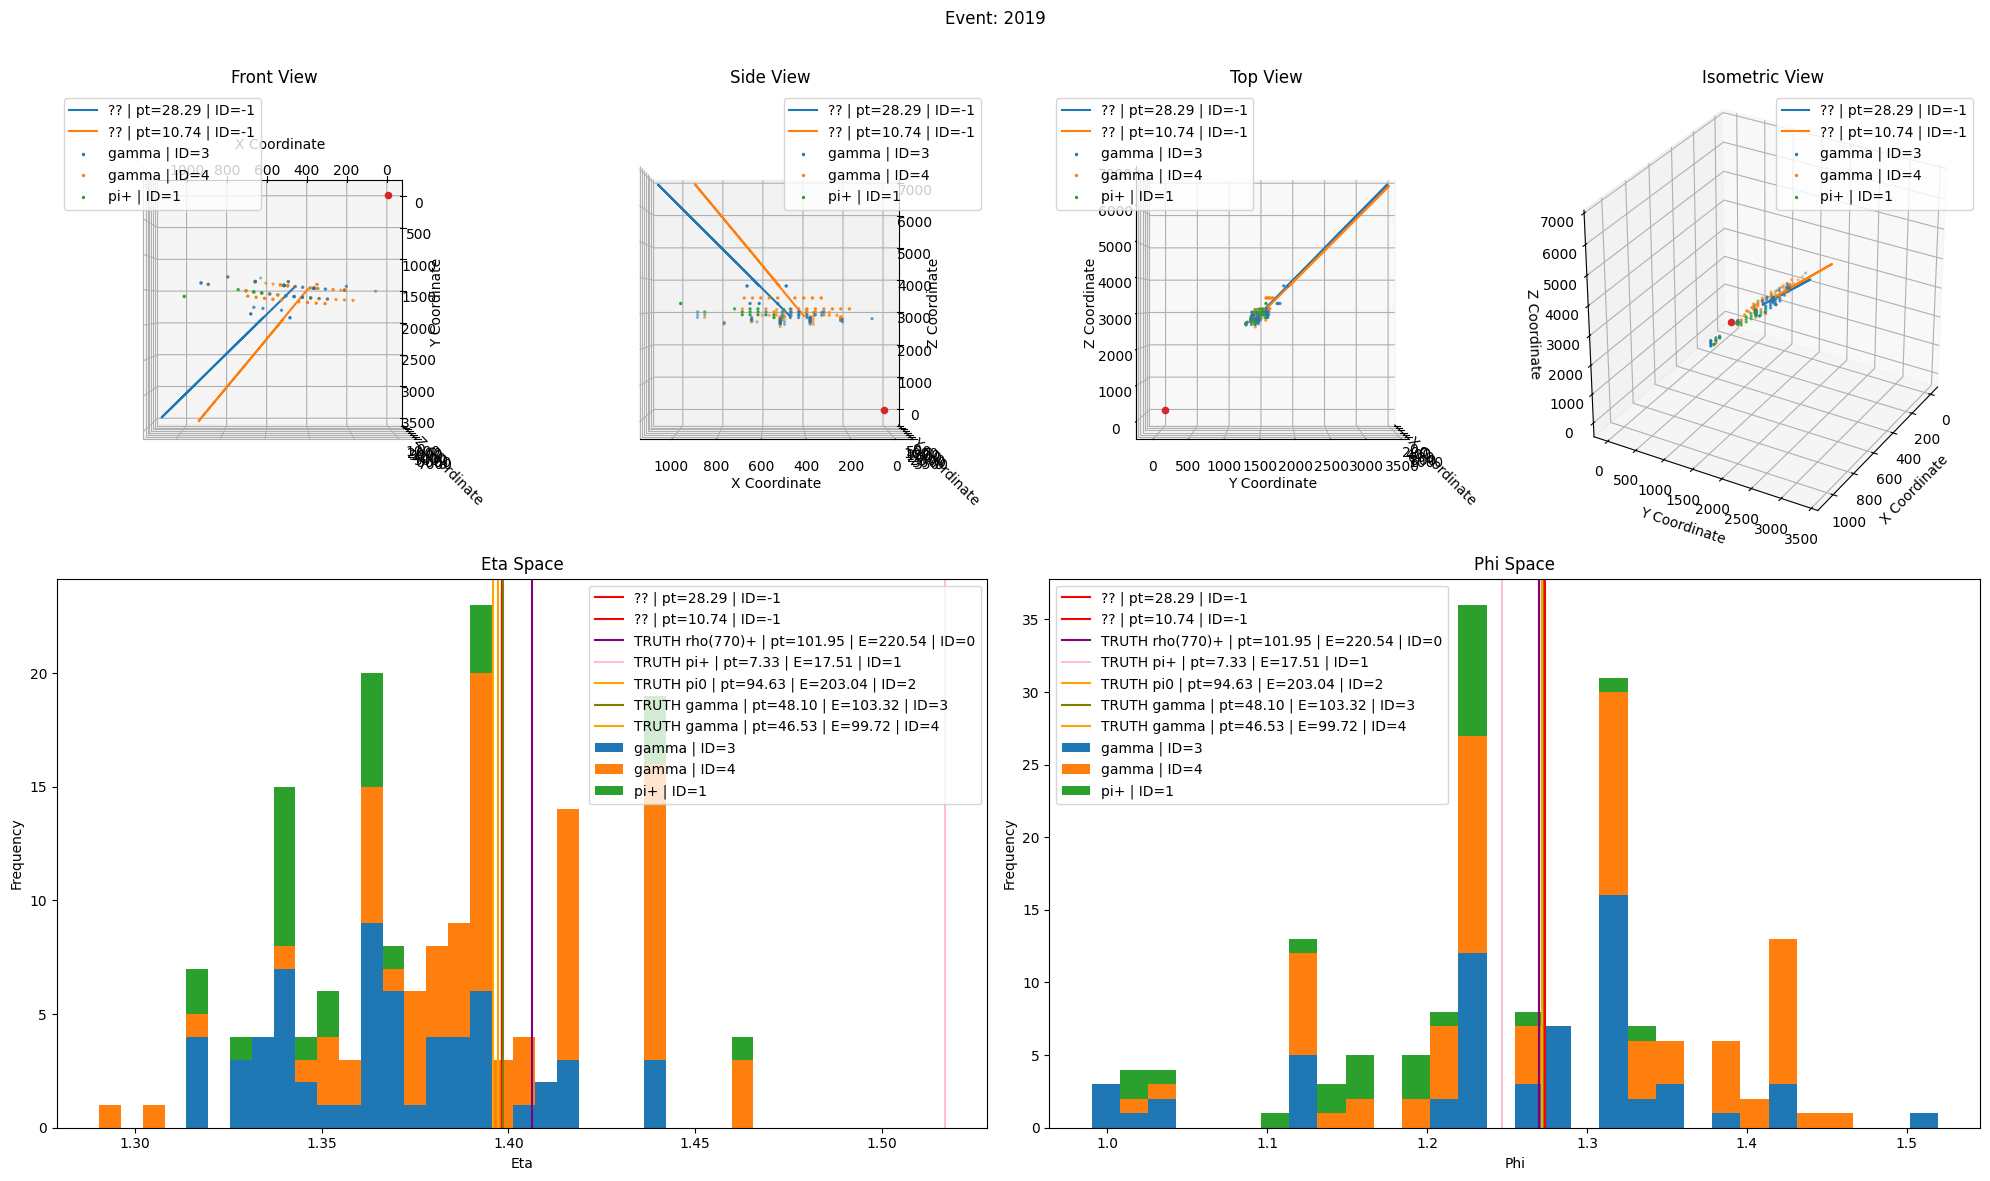

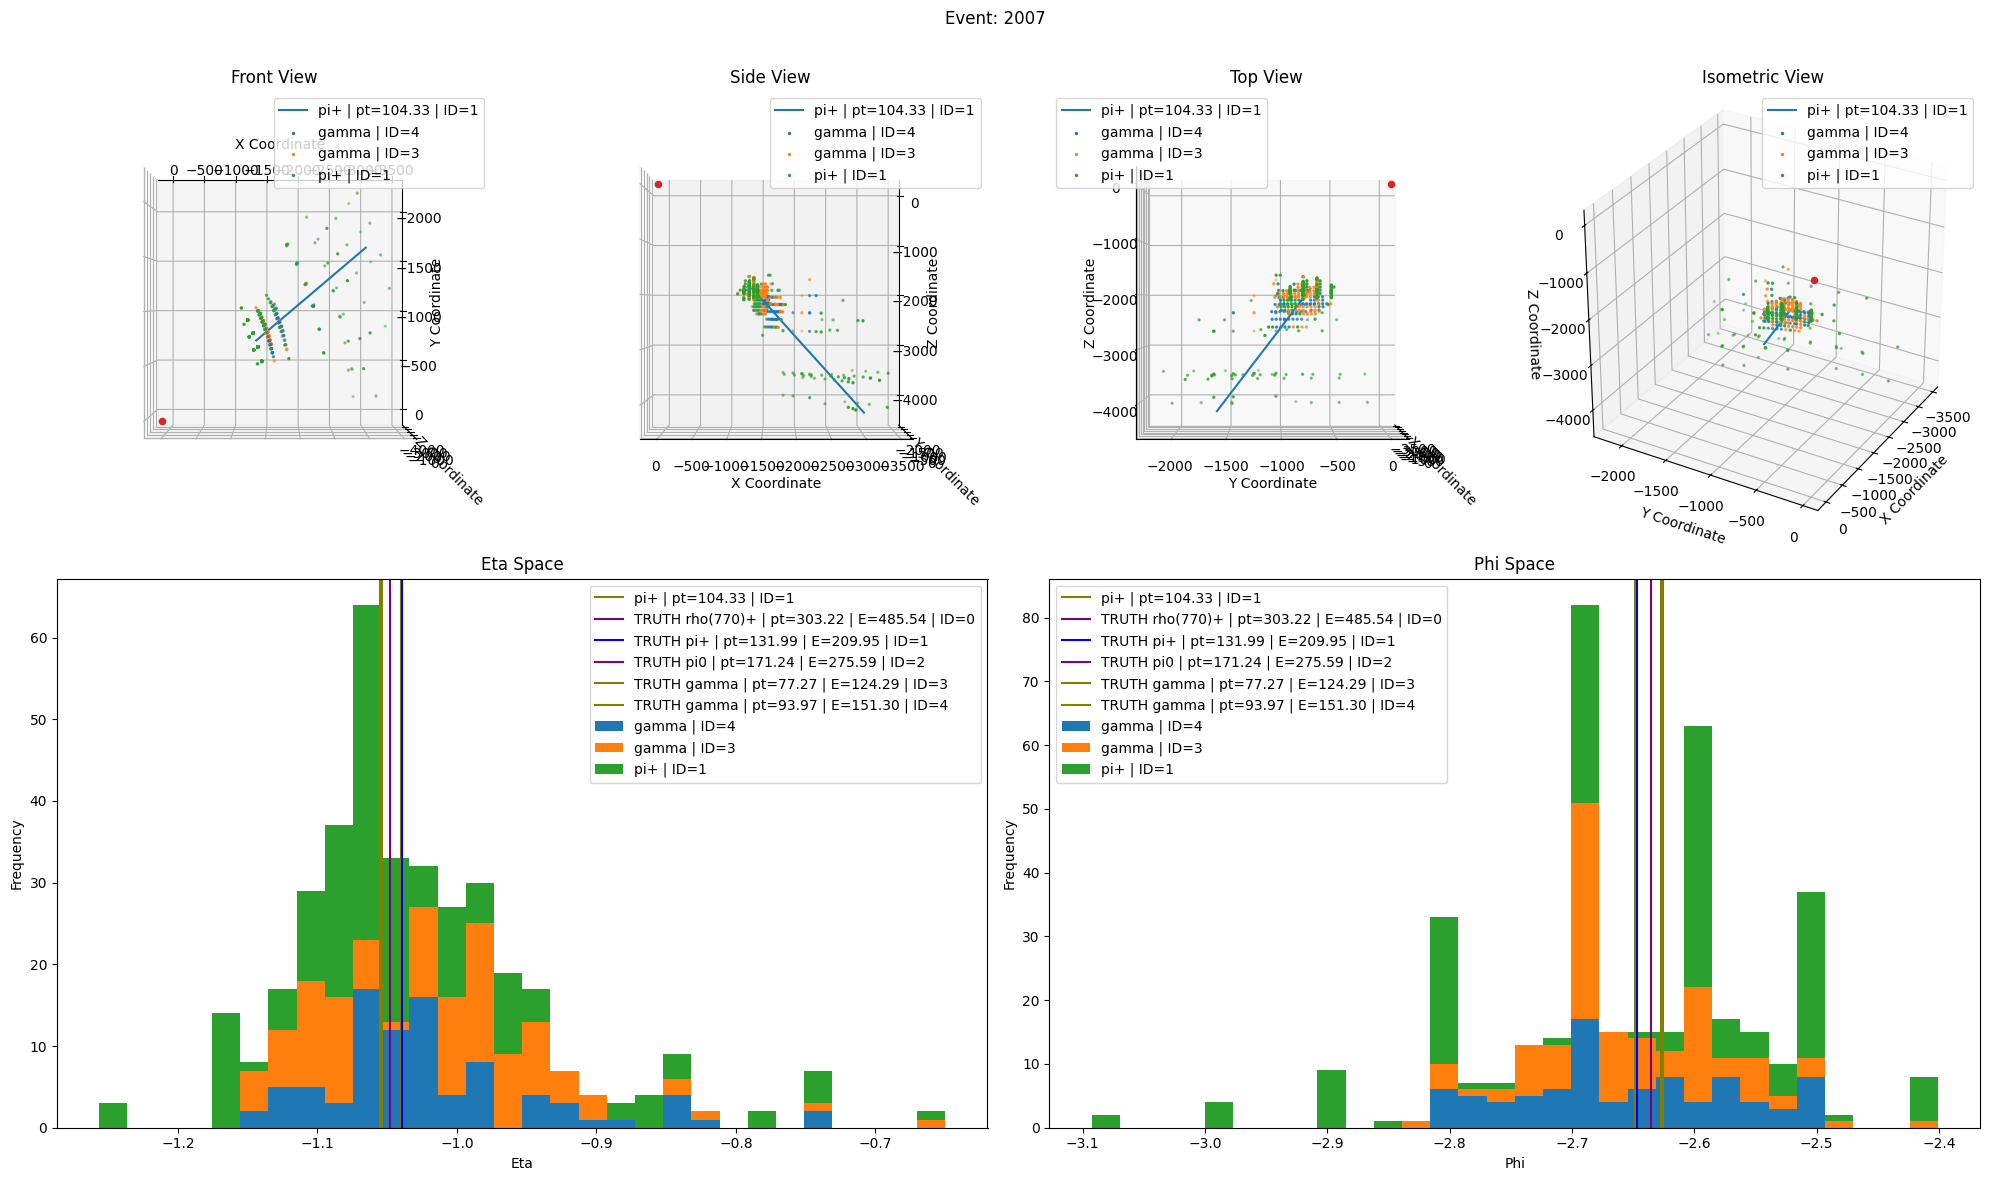

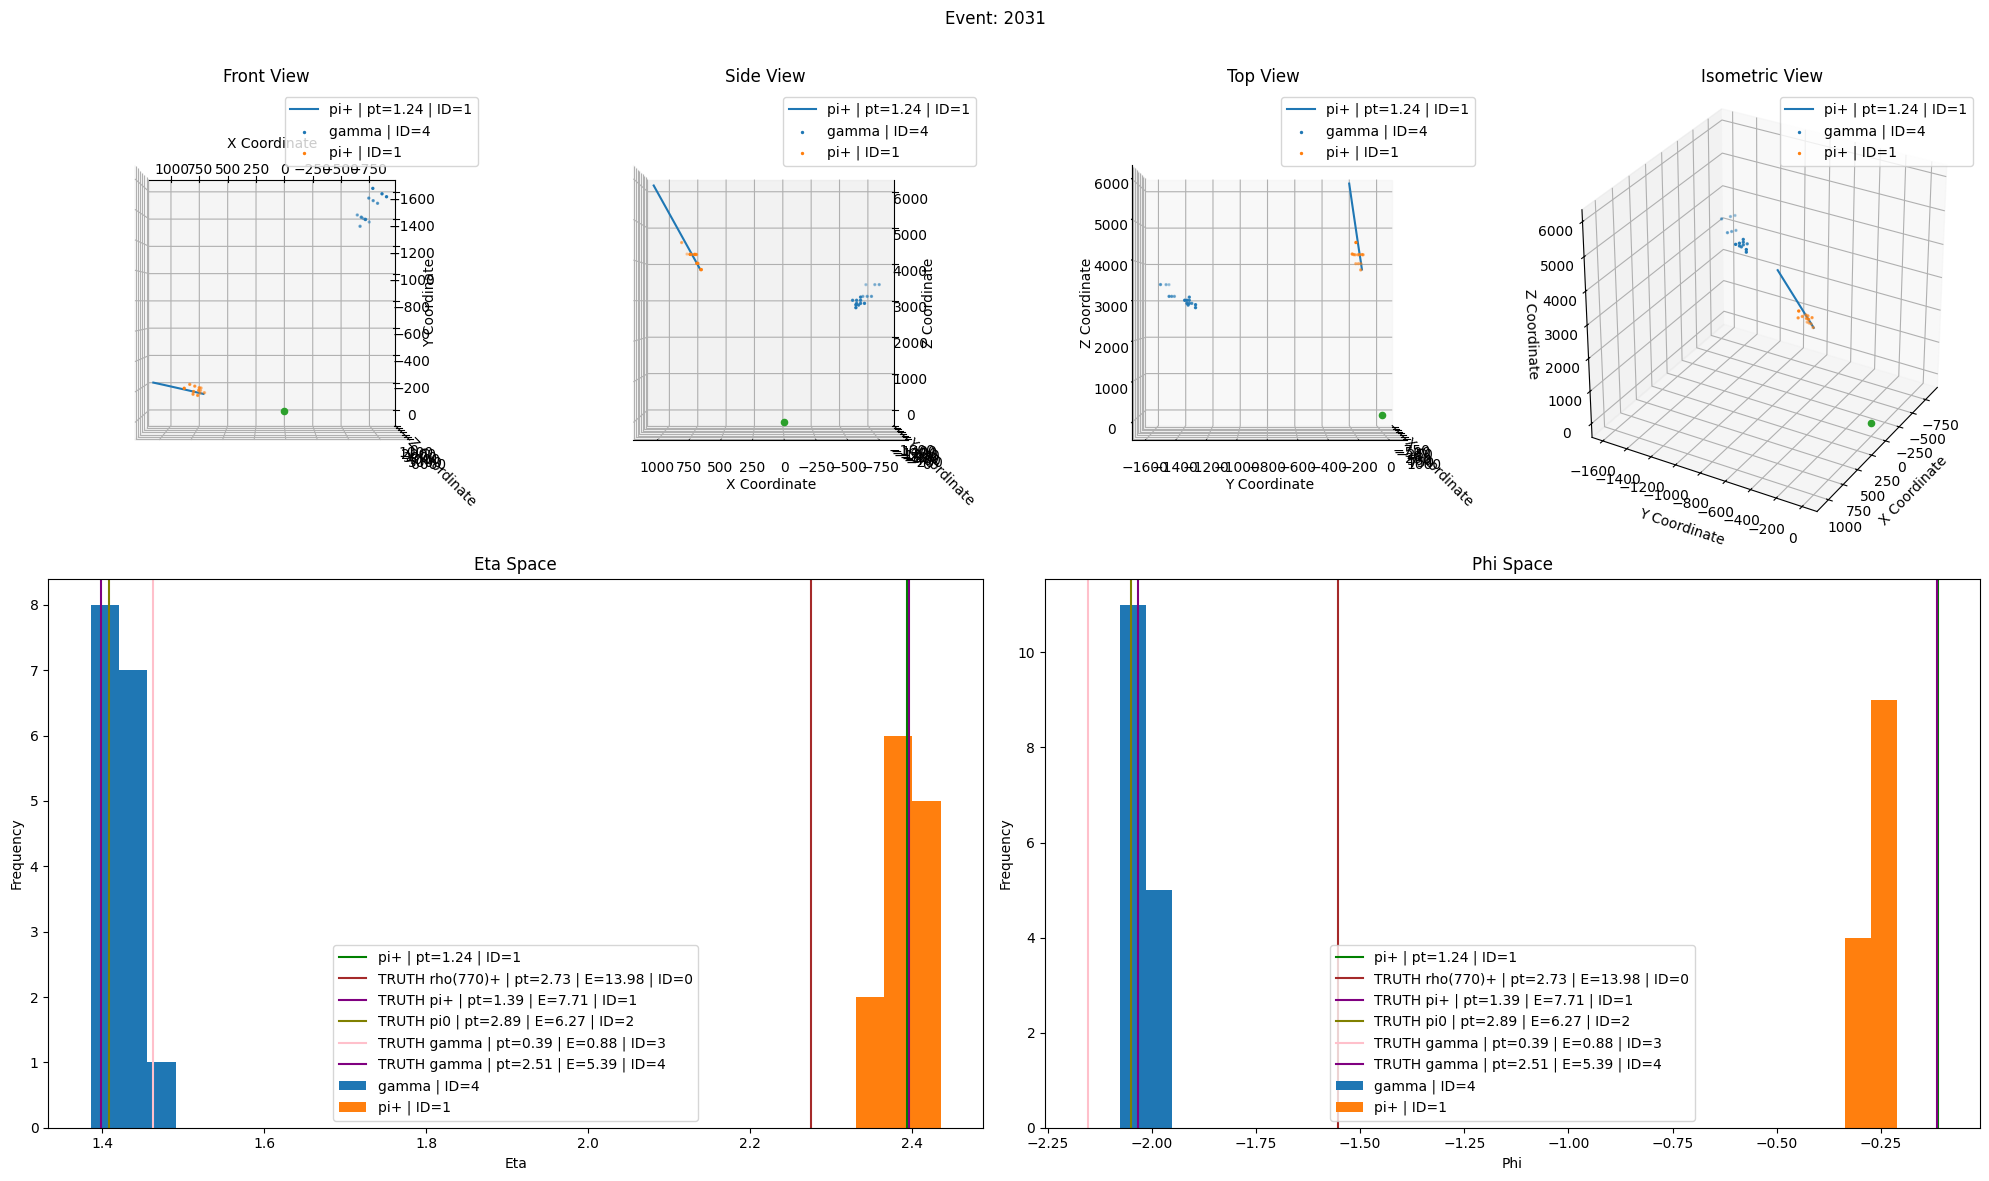

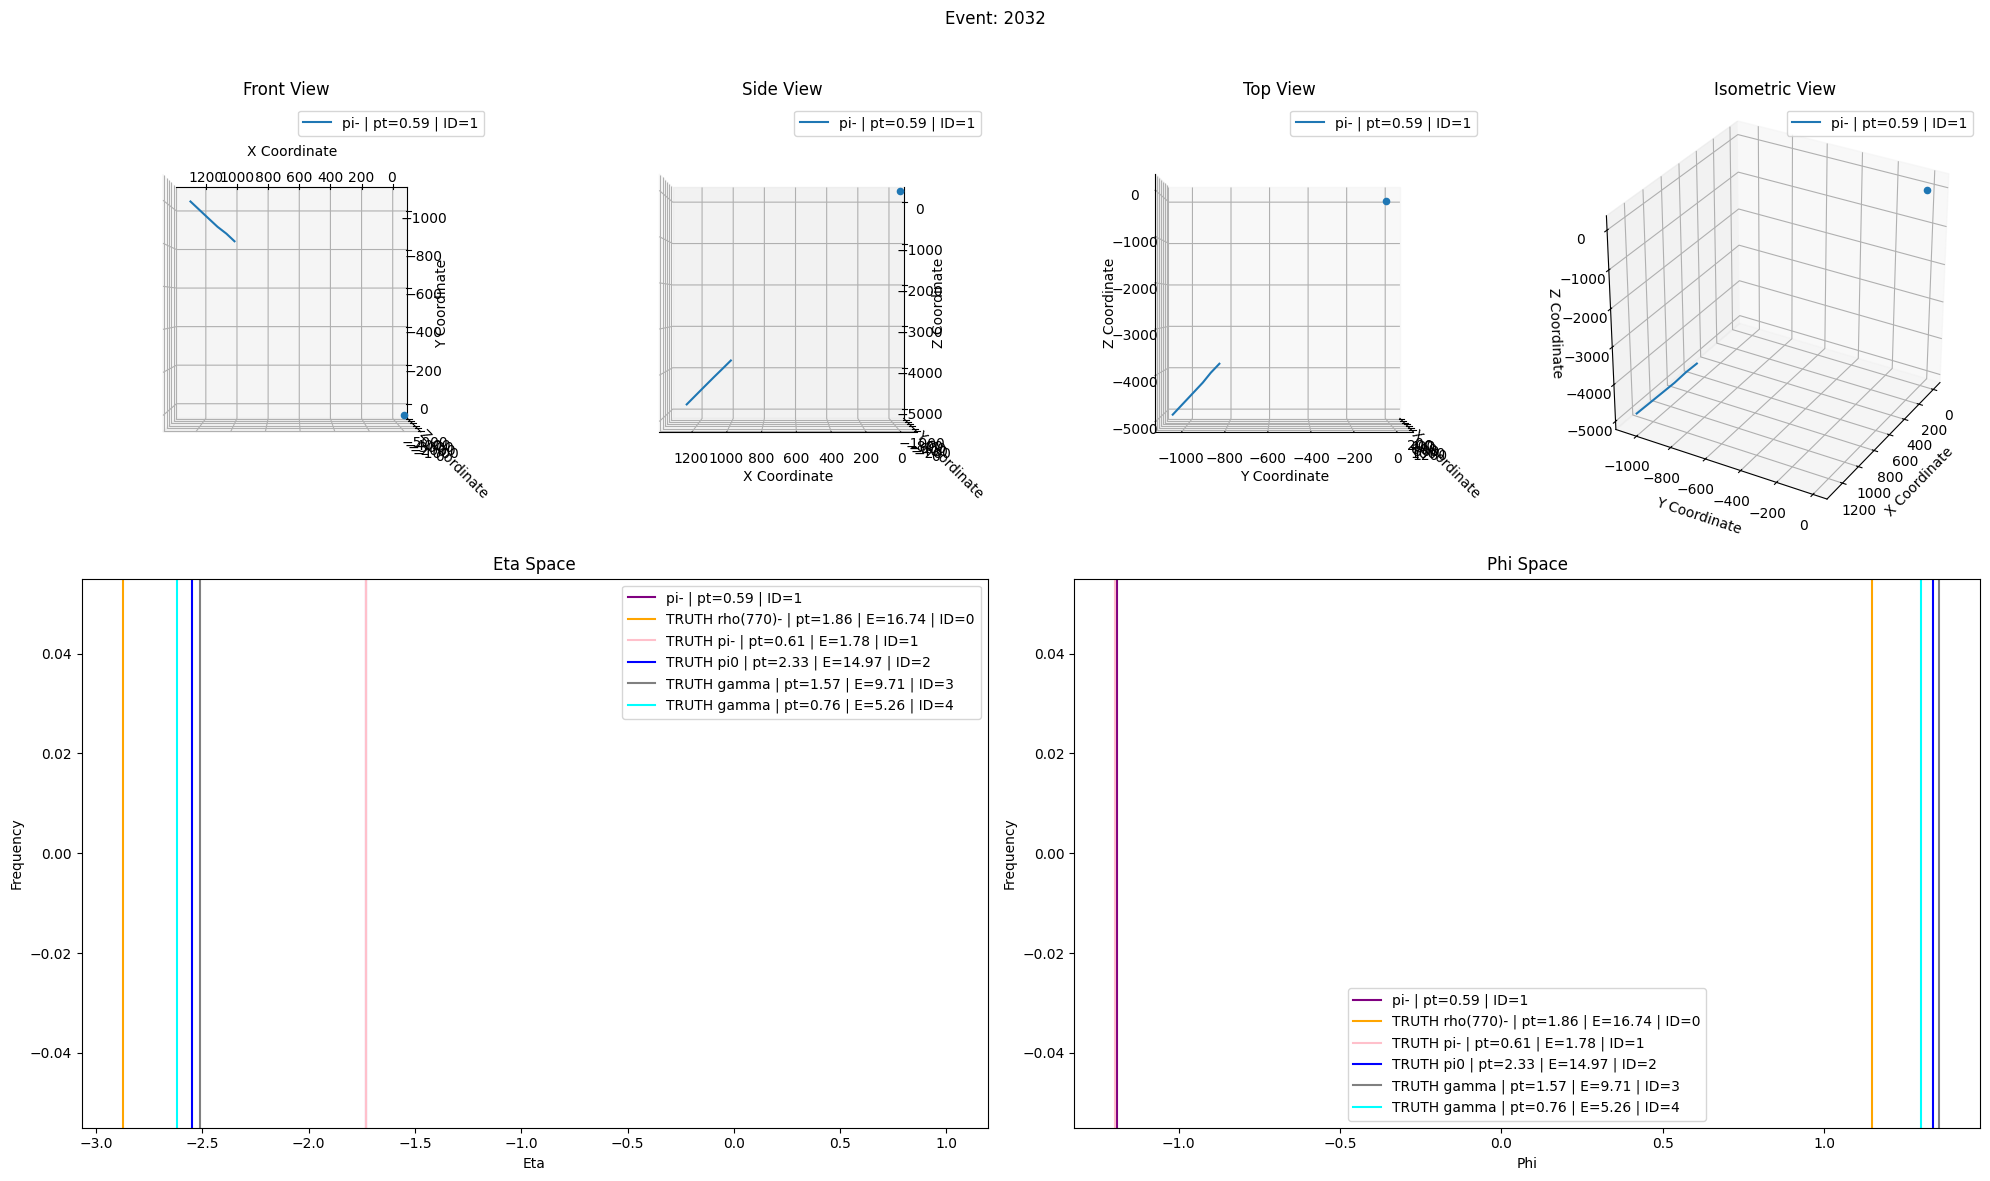

In [ ]:

root_file="/fast_scratch_1/atlas/pflow/20240614/user.mswiatlo.801169.Py8EG_A14NNPDF23LO_jj_JZ4.recon.ESD.e8514_e8528_s4185_s4114_r14977_2024.06.14.1_mltree.root/user.mswiatlo.39955735._000003.mltree.root"


root_file = "/fast_scratch_1/atlas/pflow/20240626/user.mswiatlo.mc21_13p6TeV.900148.singlerho.recon.ESD.e8537_e8455_s3986_s3874_r14060_2024.06.26.v1_mltree.root/user.mswiatlo.40097513._000001.mltree.root"


root_file = uproot.open(root_file)

render_tracks(root_file, 'rho')

root_file["EventTree;1"].keys()

In [ ]:
root_file = uproot.open(root_file)
render_tracks(root_file)

TypeError: render_tracks() missing 1 required positional argument: 'NAME'